<a href="https://colab.research.google.com/github/JosTheBossX/Applied_Machine_Learning_diabetic_retinopathy/blob/main/AML_COURSEWORK_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install livelossplot
!pip install pandas_read_xml
!pip install tensorflow-addons
!pip install vit-keras
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 36.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 38.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=d874ede62e406d057872be03dd7d117bc6d9659b342fcd76801d939735252af2
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━

In [ ]:
import shutil
import cv2
import os
import itertools
import random
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas_read_xml as pdx
import tensorflow_addons as tfa
import matplotlib.pyplot as plt


from vit_keras import vit
from collections import Counter
from google.colab import drive, files
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from IPython.display import clear_output
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Concatenate
from transformers import TFAutoModelForImageClassification
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image
from google.colab.patches import cv2_imshow

clear_output()

In [ ]:
drive.mount('/content/drive/')
clear_output()

In [ ]:
# Unzip the dataset
!mkdir dr_dataset
!unzip "/content/drive/MyDrive/AML DATA/diabetic_retinopathy_dataset.zip" -d /content/dr_dataset/
clear_output()
!rm /content/dr_dataset/.DS_Store

In [ ]:
Y_labels_data_1 = pd.read_csv('/content/drive/MyDrive/AML DATA/trainLabels15.csv')
Y_labels_data_2 = pd.read_csv('/content/drive/MyDrive/AML DATA/trainLabels19.csv')

In [ ]:
print(Y_labels_data_1.columns)
print(Y_labels_data_2.columns)

Index(['image', 'level'], dtype='object')
Index(['id_code', 'diagnosis'], dtype='object')


In [ ]:
Y_labels_data_1

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [ ]:
Y_labels_data_2

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [ ]:
Y_labels_data_2 = Y_labels_data_2.rename(columns={'id_code': 'image', 'diagnosis': 'level'})

In [ ]:
data_frame = pd.concat([Y_labels_data_1, Y_labels_data_2])

In [ ]:
data_frame.shape

(38788, 2)

In [ ]:
data_frame

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


#### a. Imbalance data

0    27615
2     6291
1     2813
3     1066
4     1003
Name: level, dtype: int64


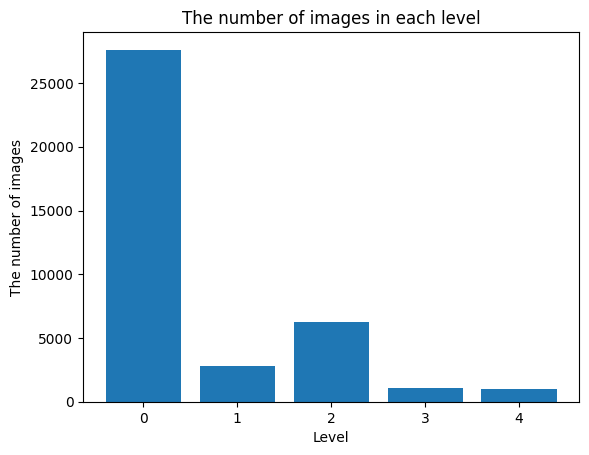

In [ ]:
images_count = data_frame['level'].value_counts()
print(images_count)
plt.bar(images_count.index, images_count.values)


plt.title('The number of images in each level')
plt.xlabel('Level')
plt.ylabel('The number of images')

plt.show()

The presence of imbalanced data can have a significant impact on the performance of machine learning models, particularly in cases where the minority class is of particular interest. In the current research project, the dataset under investigation has been identified as exhibiting imbalance in the distribution of Diabetic Retinopathy (DR) levels.

> To address this issue, a common approach is to balance the dataset by increasing the representation of the minority class and reducing the representation of the majority class(es). In the case of the current dataset, this may involve reducing the number of samples in the level 0 category and increasing the representation of the other DR levels.

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
images_temp, levels_temp = ros.fit_resample(data_frame['image'].to_frame(), data_frame['level'])
data_frame = pd.concat([images_temp, levels_temp], axis=1)
data_frame.columns = ['image', 'level']


In [ ]:
data_frame

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
138070,13395_right,4
138071,f58d37d48e42,4
138072,aa6673241154,4
138073,17453_left,4


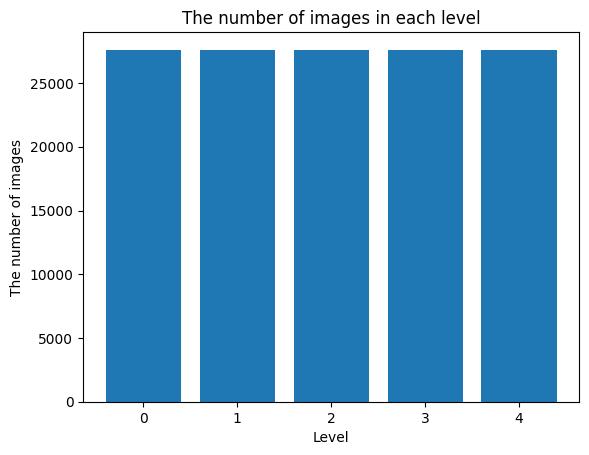

In [ ]:
images_count = data_frame['level'].value_counts()
plt.bar(images_count.index, images_count.values)
plt.title('The number of images in each level')
plt.xlabel('Level')
plt.ylabel('The number of images')
plt.show()

> After applying the RandomOverSampler technique to an imbalanced dataset, the resulting dataset will have an equal number of samples for each class. However, in some cases, the number of samples in the oversampled dataset may be too large to be handled efficiently by a machine learning model. To reduce the number of samples, one approach is to compute the average number of samples per class before oversampling and reduce the number of samples in the oversampled dataset to that average value.

In [ ]:
data_frame = data_frame.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
data_frame

,image,level
0,57a5f1015504,2
1,25670_right,0
2,5047_left,2
3,12386_right,1
4,9488_right,0
...,...,...
138070,10159_right,3
138071,a5c9a8c726b2,4
138072,40731_right,3
138073,405_right,4


In [ ]:
data_frame = data_frame[:35000]

In [ ]:
data_frame

,image,level
0,57a5f1015504,2
1,25670_right,0
2,5047_left,2
3,12386_right,1
4,9488_right,0
...,...,...
34995,6811_right,1
34996,13214_left,0
34997,19184_left,0
34998,17631_left,3


In [ ]:
data_frame['level'].unique()

array([2, 0, 1, 4, 3])

In [ ]:
data_frame['level'].value_counts()

0    7088
4    7044
1    7038
3    6926
2    6904
Name: level, dtype: int64

In [ ]:
label_counts = Counter(data_frame['level'])
print(label_counts)

Counter({0: 7088, 4: 7044, 1: 7038, 3: 6926, 2: 6904})


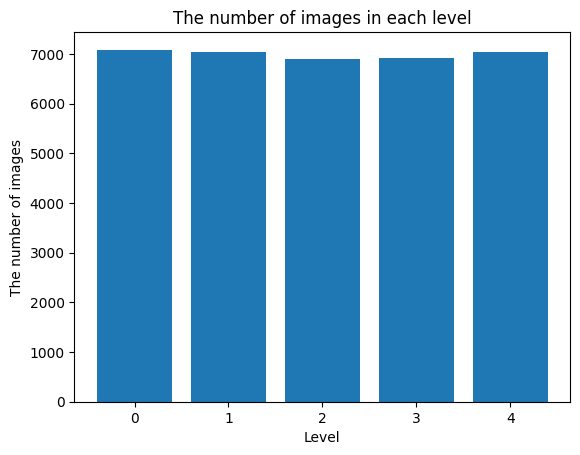

In [ ]:
# Visualization the number of image in each class
images_count = data_frame['level'].value_counts()

plt.bar(images_count.index, images_count.values)
plt.title('The number of images in each level')
plt.xlabel('Level')
plt.ylabel('The number of images')
plt.show()

#### b. Pre-processing images

In [ ]:
train_images_list = os.listdir('/content/dr_dataset')

In [ ]:
len(train_images_list)

38788

In [ ]:
train_images_list[:10]

['10515_left.jpg',
 'e6a58edc5b42.jpg',
 '30749_right.jpg',
 '33b893e18eb3.jpg',
 '17422_left.jpg',
 '42219_right.jpg',
 '15994_right.jpg',
 '42534_left.jpg',
 '40213_right.jpg',
 '8842_right.jpg']

In [ ]:
img_test = tf.io.decode_image(tf.io.read_file(os.path.join('/content/dr_dataset/a5c9a8c726b2.jpg')), channels=3, dtype=tf.dtypes.float32)
print(img_test.shape)

(1024, 1024, 3)


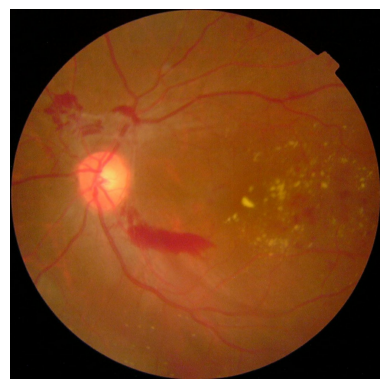

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a TensorFlow tensor/image of type tf.float32
image = img_test # Your tf.float32 image

# Convert the image to a numpy array
image_np = image.numpy()

# Scale the values to the range [0, 255]
image_np = (image_np * 255).astype(np.uint8)

# Display the image using Matplotlib
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
img_test = tf.io.decode_image(tf.io.read_file(os.path.join('/content/dr_dataset',train_images_list[10])), channels=3, dtype=tf.dtypes.float32)
print(img_test.shape)

(832, 1024, 3)


> It is important to ensure that all images in the dataset have a consistent size and format before they are processed and used for model training. In the context of image processing and machine learning, images are typically represented as tensors with a fixed size and number of channels.

> Upon analyzing the images in the dataset, it is evident that the images have varying sizes, with some images having dimensions of (832, 1023)* while others have dimensions of (1021, 1024)*. This variability in size can pose a challenge for model training, as the model may struggle to learn features or patterns that are relevant across different image sizes.

In [ ]:
path = '/content/dr_dataset'

min_size = float('inf')
max_size = float('-inf')
size_counts = Counter()

for filename in os.listdir(path):
    img_path = os.path.join(path, filename)
    img = tf.io.read_file(img_path)
    try:
      img = tf.image.decode_image(img, channels=3)
    except:
      print(img_path)
      continue
    height, width, _ = img.shape

    min_size = min(min_size, height, width)
    max_size = max(max_size, height, width)

    size_counts[(height, width)] += 1

most_common_size, _ = size_counts.most_common(1)[0]

print("Minimum size:", min_size)
print("Maximum size:", max_size)
print("Most common size:", most_common_size)

Minimum size: 273
Maximum size: 2612
Most common size: (851, 1024)


> As you can see, most common size is about 851 * 1024; However, due to the limitation on computing, we just need resize it to 224, 224 for further research

In [ ]:
print(type(data_frame['level'][0]))
data_frame['level'] = data_frame['level'].astype(str)

<class 'numpy.int64'>


<ipython-input-45-7620f4d4e1d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['level'] = data_frame['level'].astype(str)


First of all, before you create the train generator, you need to have mapping data from your image to the dataframe, it is neccessary step before training the data, and you need to make sure that the image name in your dataframe have matched with the name of the image in the folder (included the type of image)

In [ ]:
data_frame['image'] = data_frame['image'].apply(lambda x: f"{x}.jpg")

<ipython-input-46-066b1e9e7598>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['image'] = data_frame['image'].apply(lambda x: f"{x}.jpg")


In [ ]:
data_frame

,image,level
0,57a5f1015504.jpg,2
1,25670_right.jpg,0
2,5047_left.jpg,2
3,12386_right.jpg,1
4,9488_right.jpg,0
...,...,...
34995,6811_right.jpg,1
34996,13214_left.jpg,0
34997,19184_left.jpg,0
34998,17631_left.jpg,3


### 3.5 Creating validation method

> Creating a validation method in AI training is crucial to ensure that the trained model performs accurately on unseen data. Hence, we are going to create some functions that can validate how well an AI model performs on unseen data.

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  conf_mat = confusion_matrix(y_true, y_pred)

  classes = [0, 1, 2, 3, 4]
  plt.imshow(conf_mat, cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  thresh = conf_mat.max() / 2.
  for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
      plt.text(j, i, conf_mat[i, j],
              horizontalalignment='center',
              color='white' if conf_mat[i, j] > thresh else 'black')
  plt.show()
  return None

In [ ]:
def accuracy_calculation(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Length of y_true and y_pred must be the same"
    num_correct = sum(t == p for t, p in zip(y_true, y_pred))
    accuracy = num_correct / len(y_true)
    return accuracy

### 3.6 Data Splitting Experiment

In this section, we will delve into the practical aspect of the validation process, by designing and conducting a data splitting experiment. The aim is to assess the AI model's performance on separate training and validation datasets, ensuring a robust evaluation of its generalizability.

Moreover, to make this experiment to maintain consistency and enable a fair comparison of results. We will discuss various data splitting techniques and their application in the context of our experiment using the AlexNet architecture and a predefined image processing function.

#### Train/Test/Validation: 80/10/10

In [ ]:
train_data, test_plus_val_data = train_test_split(data_frame, test_size=0.2, random_state=42)
test_data, validate_data  = train_test_split(test_plus_val_data, test_size=0.5, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(28000, 2)
(3500, 2)
(3500, 2)


In [ ]:
def custom_preprocessing_image(image):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_up_down(img), lambda: img)

    angle_rad = tf.random.uniform((), minval=-2 * np.pi, maxval=2 * np.pi)
    img = tfa.image.rotate(img, angle_rad)

    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_brightness(img, max_delta=0.1),
                  lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_contrast(img, lower=0.9, upper=1.1),
                  lambda: img)
    gray_image = tf.image.rgb_to_grayscale(img)

    return gray_image

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_image
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 28000 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.


##### Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

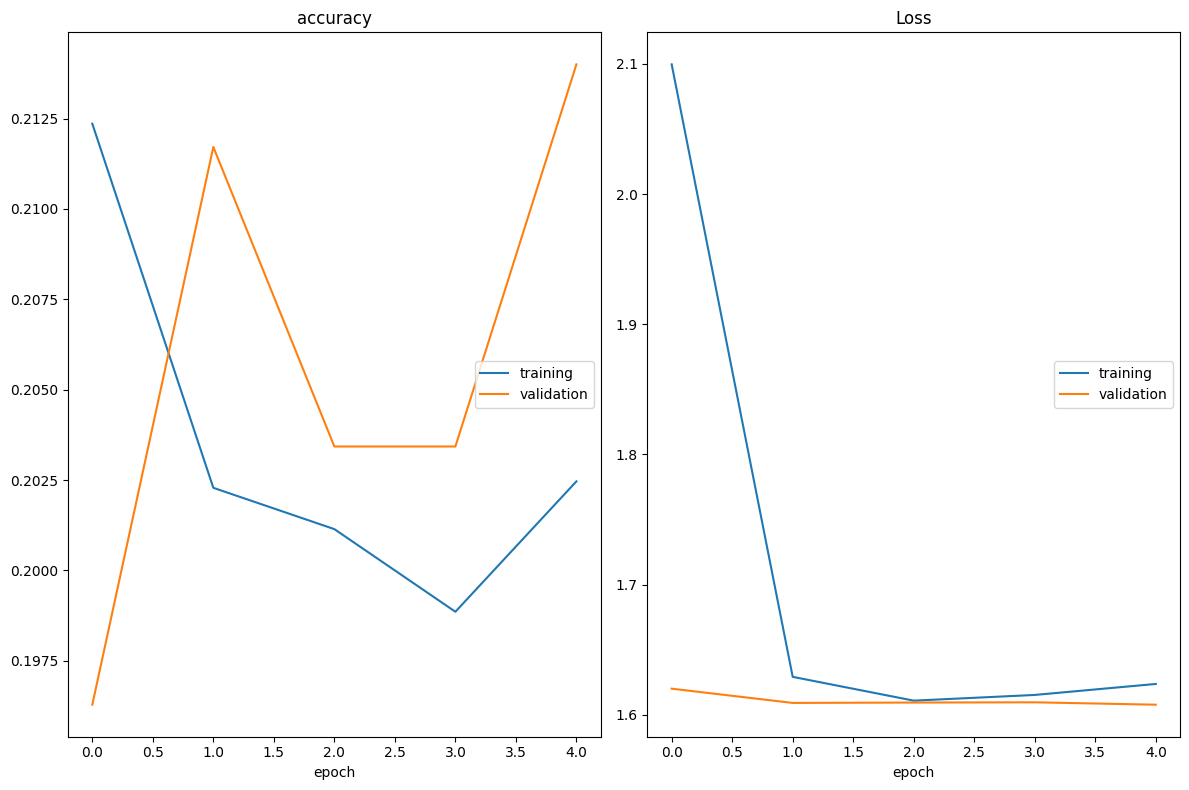

accuracy
	training         	 (min:    0.199, max:    0.212, cur:    0.202)
	validation       	 (min:    0.196, max:    0.214, cur:    0.214)
Loss
	training         	 (min:    1.611, max:    2.100, cur:    1.624)
	validation       	 (min:    1.608, max:    1.620, cur:    1.608)
875/875 [==============================] - 905s 1s/step - loss: 1.6236 - accuracy: 0.2025 - val_loss: 1.6077 - val_accuracy: 0.2140
Epoch 6/10
875/875 [==============================] - ETA: 0s - loss: 1.6226 - accuracy: 0.2064

In [ ]:
model = alexnet_model.fit(train_generator, epochs =10, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

###### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

3500/3500 [==============================] - 101s 29ms/step


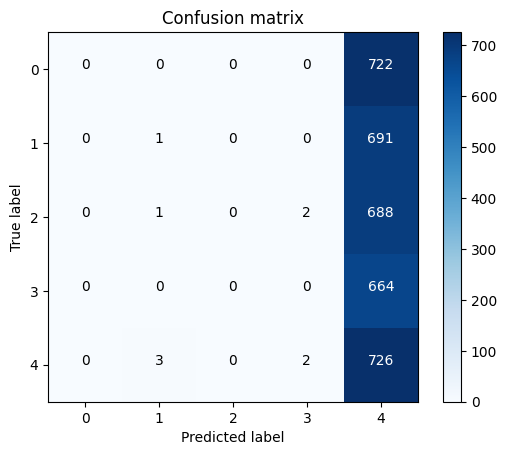

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.2077142857142857


> Upon analyzing the first ten epochs of our model, we observe that the training accuracy is at a mere 19.9% while the validation accuracy is slightly higher at 20.14%. Moreover, the testing accuracy is hovering around 20.77%. These figures strongly suggest that the current model is underperforming, manifesting an underfitting issue. Underfitting occurs when the model does not capture the underlying structure of the data, thus performing poorly in prediction tasks.

> Given these circumstances, one of the viable solutions to improve the model's predictive accuracy is to increase the number of training epochs. This adjustment would provide the model with more opportunities to learn from the training data, and as a result, it may better grasp the essential patterns needed for effective prediction.

> Nonetheless, it is important to remember that the primary focus of this experiment lies in understanding the impact of data splitting on the model's accuracy. Therefore, while it is important to strive for improved accuracy, our emphasis should remain on exploring how different methods of data partitioning affect the model's performance.

#### Train/Test/Validation: 70/20/10

In [ ]:
train_data, test_plus_val_data = train_test_split(data_frame, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(test_plus_val_data, test_size=0.25, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(24500, 2)
(7875, 2)
(3500, 2)


In [ ]:
def custom_preprocessing_image(image):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_up_down(img), lambda: img)

    angle_rad = tf.random.uniform((), minval=-2 * np.pi, maxval=2 * np.pi)
    img = tfa.image.rotate(img, angle_rad)

    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_brightness(img, max_delta=0.1),
                  lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_contrast(img, lower=0.9, upper=1.1),
                  lambda: img)
    gray_image = tf.image.rgb_to_grayscale(img)

    return gray_image

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_image
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 24500 validated image filenames belonging to 5 classes.
Found 7875 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.


##### Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model = alexnet_model.fit(train_generator, epochs =10, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

###### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

> Upon careful review of the initial ten epochs of our model, we find that the training accuracy is situated at a relatively low 19.95%, with the validation accuracy presenting slightly better at 21.14%. These accuracy figures provide a significant understanding of the impact of data splitting on the performance of the model. Specifically, we can deduce that a 70/20/10 train/validation/test split ratio appears to yield a higher accuracy percentage compared to an 80/10/10 split.

#### Train/Test/Validation: 70/15/15

In [ ]:
train_data, test_plus_val_data = train_test_split(data_frame, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_plus_val_data, test_size=0.5, random_state=42)


In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(24500, 2)
(5250, 2)
(5250, 2)


In [ ]:
def custom_preprocessing_image(image):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_up_down(img), lambda: img)

    angle_rad = tf.random.uniform((), minval=-2 * np.pi, maxval=2 * np.pi)
    img = tfa.image.rotate(img, angle_rad)

    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_brightness(img, max_delta=0.1),
                  lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_contrast(img, lower=0.9, upper=1.1),
                  lambda: img)
    gray_image = tf.image.rgb_to_grayscale(img)

    return gray_image

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_image
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 24500 validated image filenames belonging to 5 classes.
Found 5250 validated image filenames belonging to 5 classes.
Found 5250 validated image filenames belonging to 5 classes.


##### Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

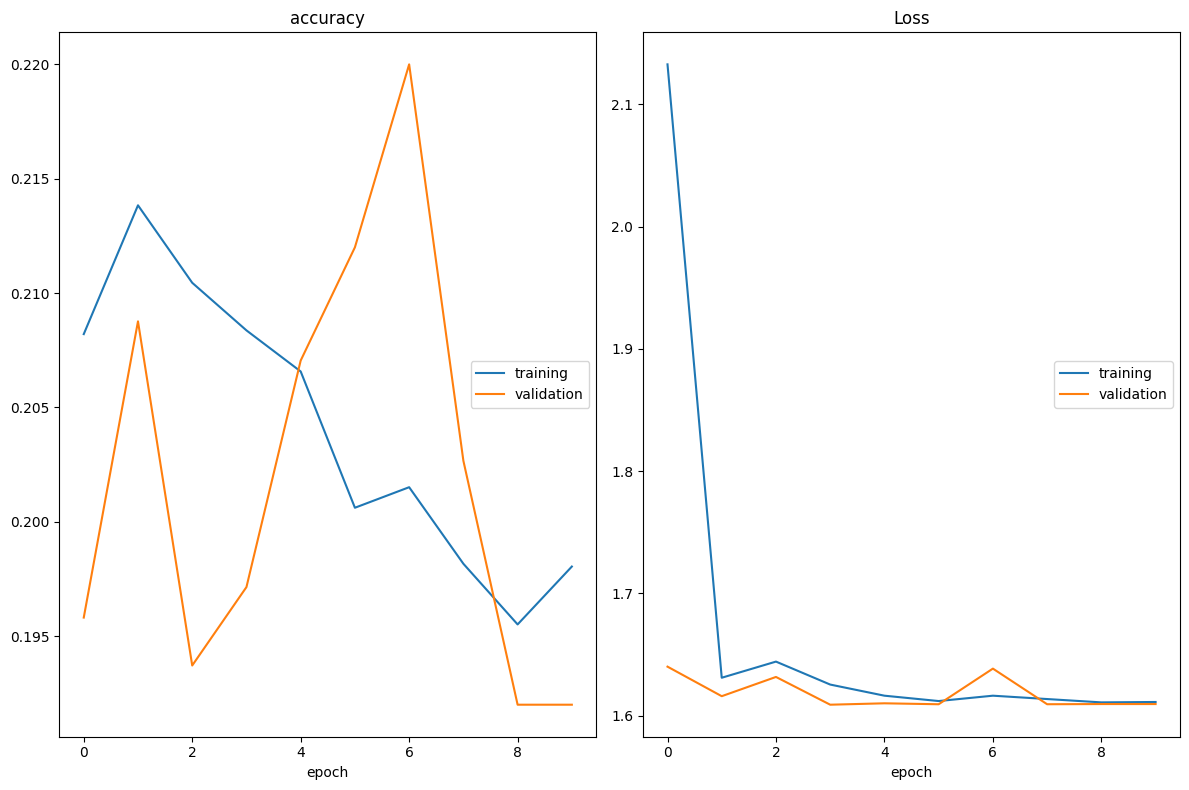

accuracy
	training         	 (min:    0.196, max:    0.214, cur:    0.198)
	validation       	 (min:    0.192, max:    0.220, cur:    0.192)
Loss
	training         	 (min:    1.611, max:    2.133, cur:    1.611)
	validation       	 (min:    1.609, max:    1.640, cur:    1.609)
766/766 [==============================] - 817s 1s/step - loss: 1.6112 - accuracy: 0.1980 - val_loss: 1.6095 - val_accuracy: 0.1920


In [ ]:
model = alexnet_model.fit(train_generator, epochs =10, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

###### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

5250/5250 [==============================] - 148s 28ms/step


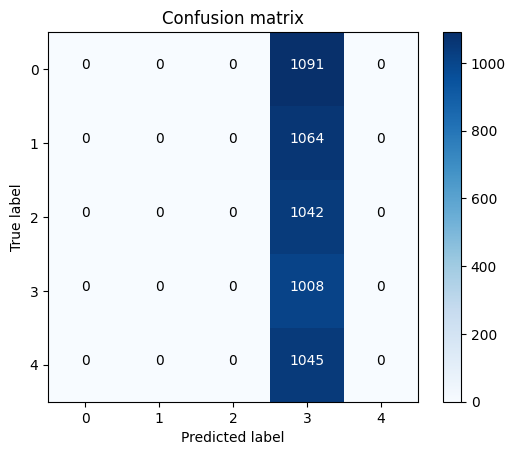

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.192


> Upon implementing a 70/15/15 train/validation/test split on our dataset, we observe a decrease in performance across all metrics. The training, validation, and testing accuracies register at 19.8%, 19.2%, and 19.2% respectively, which are notably lower than those obtained with a 70/20/10 split.

> This reduction in accuracy implies that, at least for this particular model and dataset, a 70/20/10 split may be more effective in enhancing the model's predictive capabilities. The decrease in performance when employing a 70/15/15 split could potentially be attributed to the reduced size of the validation set, which might provide a less robust estimation of out-of-sample performance during the training phase.

#### Train/Test/Validation: 60/20/20

In [ ]:
train_data, test_plus_val_data = train_test_split(data_frame, test_size=0.4, random_state=42)
test_data, val_data = train_test_split(test_plus_val_data, test_size=0.5, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(21000, 2)
(7000, 2)
(7000, 2)


In [ ]:
def custom_preprocessing_image(image):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_up_down(img), lambda: img)

    angle_rad = tf.random.uniform((), minval=-2 * np.pi, maxval=2 * np.pi)
    img = tfa.image.rotate(img, angle_rad)

    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_brightness(img, max_delta=0.1),
                  lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_contrast(img, lower=0.9, upper=1.1),
                  lambda: img)
    gray_image = tf.image.rgb_to_grayscale(img)

    return gray_image

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_image
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 21000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.


##### Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

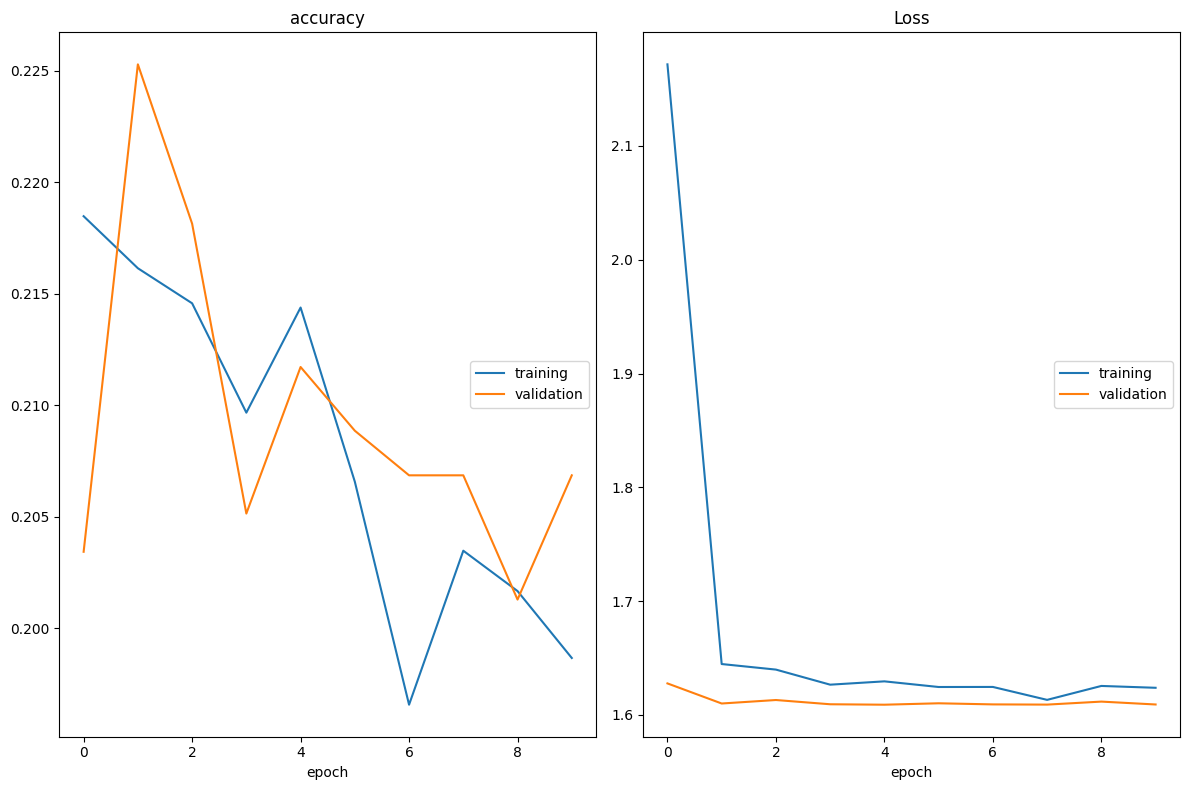

accuracy
	training         	 (min:    0.197, max:    0.218, cur:    0.199)
	validation       	 (min:    0.201, max:    0.225, cur:    0.207)
Loss
	training         	 (min:    1.613, max:    2.172, cur:    1.624)
	validation       	 (min:    1.609, max:    1.628, cur:    1.609)
657/657 [==============================] - 803s 1s/step - loss: 1.6239 - accuracy: 0.1987 - val_loss: 1.6092 - val_accuracy: 0.2069


In [ ]:
model = alexnet_model.fit(train_generator, epochs =10, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

###### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

  25/7000 [..............................] - ETA: 3:49

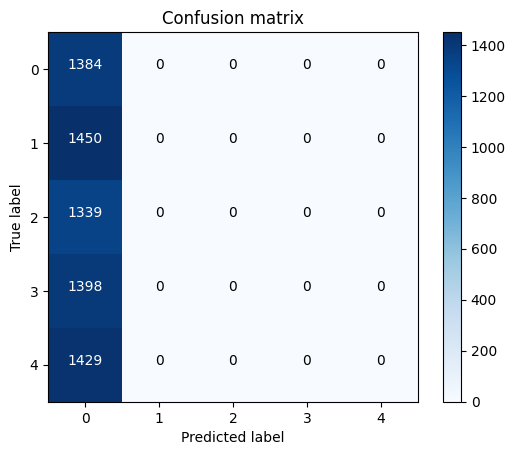

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

> Upon employing a 60/20/20 train/validation/test data split, the accuracy metrics observed are 19.87% for training, 20.69% for validation, and 20.99% for testing. This indicates that this particular split ratio results in an improvement in both validation and testing accuracies compared to the 70/15/15 split, though it slightly underperforms compared to the 70/20/10 split.

> This implies that reducing the size of the training set and increasing the size of the validation and test sets may result in a model that better generalizes to unseen data, as evidenced by the higher testing accuracy. However, this also suggests that there might be a trade-off between the size of the training set and the ability of the model to generalize, as the training accuracy is slightly lower compared to the 70/20/10 split.

#### Train/Test/Validation: 76/19/05

In [ ]:
train_data, validate_data = train_test_split(data_frame, test_size=0.05, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(26600, 2)
(6650, 2)
(1750, 2)


In [ ]:
def custom_preprocessing_image(image):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_up_down(img), lambda: img)

    angle_rad = tf.random.uniform((), minval=-2 * np.pi, maxval=2 * np.pi)
    img = tfa.image.rotate(img, angle_rad)

    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_brightness(img, max_delta=0.1),
                  lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_contrast(img, lower=0.9, upper=1.1),
                  lambda: img)
    gray_image = tf.image.rgb_to_grayscale(img)

    return gray_image

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_image
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


##### Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

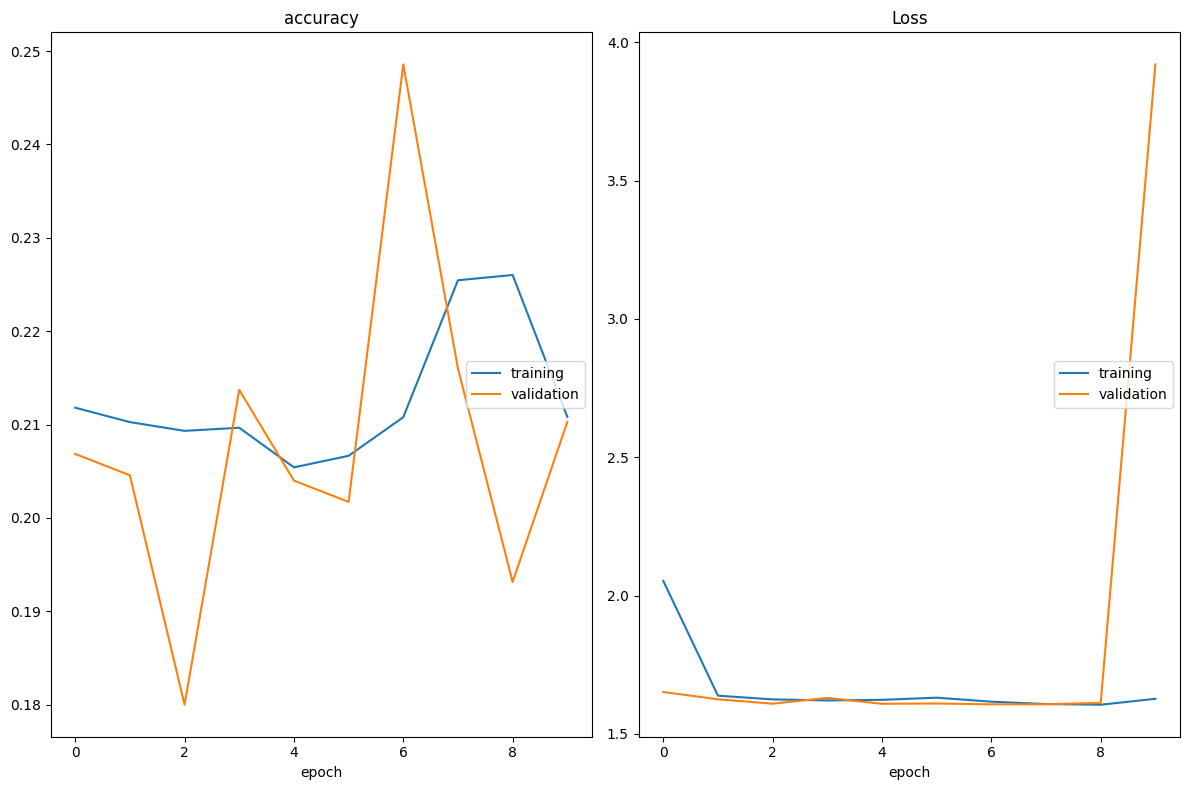

accuracy
	training         	 (min:    0.205, max:    0.226, cur:    0.211)
	validation       	 (min:    0.180, max:    0.249, cur:    0.210)
Loss
	training         	 (min:    1.605, max:    2.053, cur:    1.626)
	validation       	 (min:    1.607, max:    3.920, cur:    3.920)
832/832 [==============================] - 803s 965ms/step - loss: 1.6265 - accuracy: 0.2108 - val_loss: 3.9203 - val_accuracy: 0.2103


In [ ]:
model = alexnet_model.fit(train_generator, epochs =10, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

###### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

6650/6650 [==============================] - 189s 28ms/step


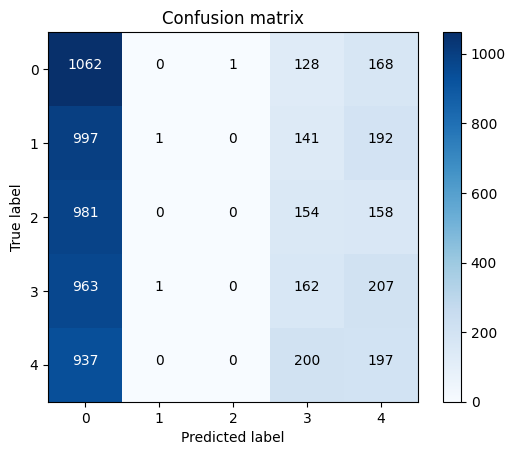

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.2138345864661654


> When we apply a 76/19/05 train/validation/test split to our dataset, we observe that the accuracy metrics improve across all three categories. Specifically, the training accuracy increases to 21.08%, the validation accuracy to 21.25%, and the testing accuracy to 21.38%.

> These results suggest that this particular split ratio yields a better model performance than the previously tested 60/20/20, 70/15/15, and 70/20/10 configurations, at least within the context of the limited number of epochs under review. It appears that a larger training set combined with a moderate validation set and a smaller testing set might be beneficial for this specific dataset and model.

### 3.6. Picture Refine 1 - Training Model

#### a. Picture Refine

In [ ]:
train_data, validate_data = train_test_split(data_frame, test_size=0.05, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(26600, 2)
(6650, 2)
(1750, 2)


In [ ]:
def custom_preprocessing_image(image):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_up_down(img), lambda: img)

    angle_rad = tf.random.uniform((), minval=-2 * np.pi, maxval=2 * np.pi)
    img = tfa.image.rotate(img, angle_rad)

    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_brightness(img, max_delta=0.1),
                  lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_contrast(img, lower=0.9, upper=1.1),
                  lambda: img)
    gray_image = tf.image.rgb_to_grayscale(img)

    return gray_image

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_image
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


#### b. Training Model

##### b.1. Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

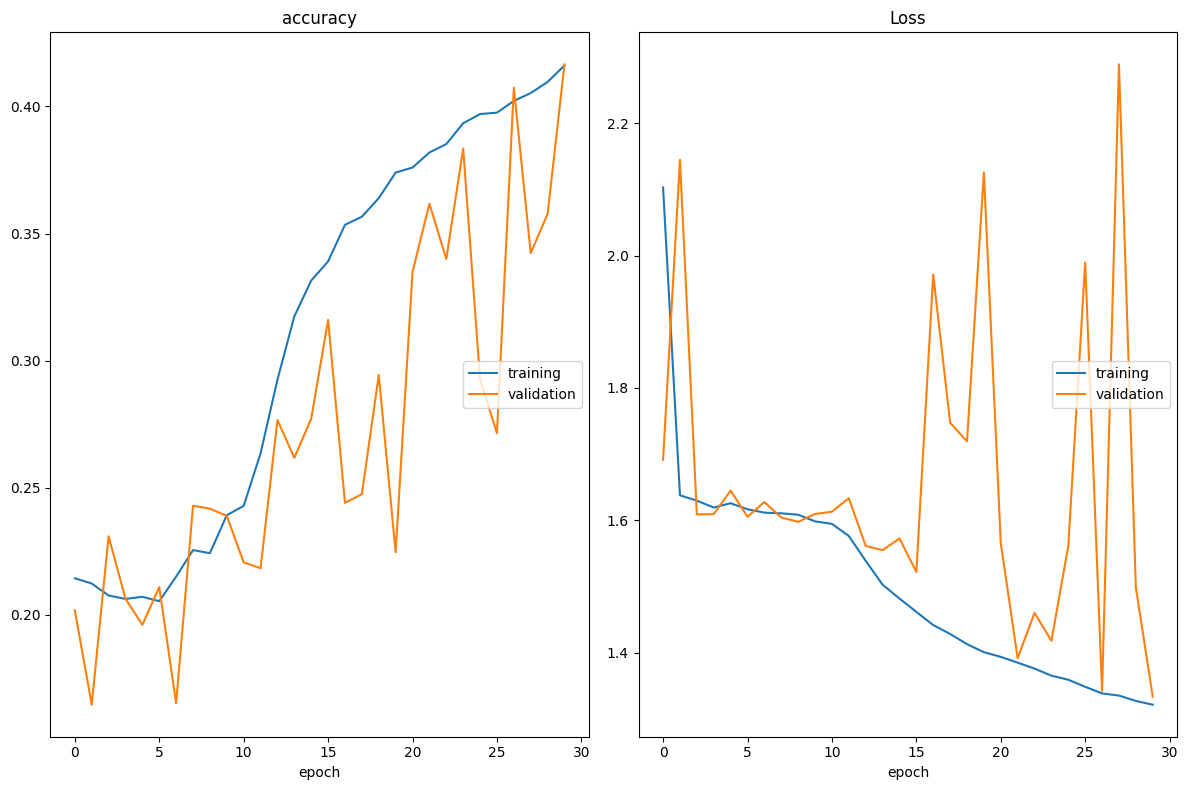

accuracy
	training         	 (min:    0.205, max:    0.416, cur:    0.416)
	validation       	 (min:    0.165, max:    0.417, cur:    0.417)
Loss
	training         	 (min:    1.321, max:    2.103, cur:    1.321)
	validation       	 (min:    1.333, max:    2.289, cur:    1.333)
832/832 [==============================] - 745s 896ms/step - loss: 1.3214 - accuracy: 0.4161 - val_loss: 1.3334 - val_accuracy: 0.4166


In [ ]:
model = alexnet_model.fit(train_generator, epochs =30, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

###### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

6650/6650 [==============================] - 178s 27ms/step


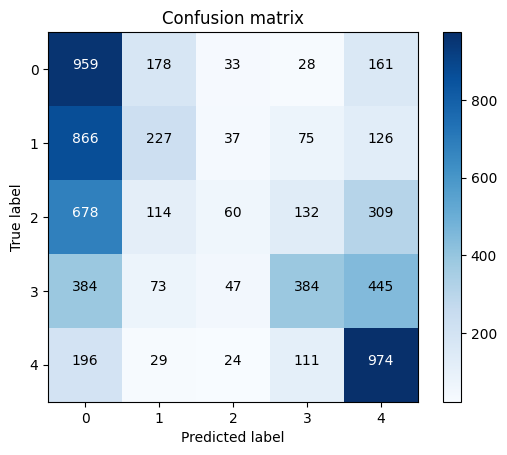

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.391578947368421


> In this section, we aim to explore how pre-processing images can influence model accuracy. For this purpose, we will train the AlexNet model over a span of 30 epochs and evaluate its performance.

> The pre-processing function custom_preprocessing_image(image) outlined above applies several transformations to the input image, which include scaling the image pixels, random horizontal and vertical flipping, random rotation, random brightness and contrast adjustments, and finally converting the image to grayscale.

> Upon training the AlexNet model with the custom pre-processing function for image data over 30 epochs, we observe a significant improvement in model performance across all categories. Specifically, the training accuracy improves to 41.61%, the validation accuracy to 41.66%, and the testing accuracy to 39.15%. This can lead to the fact that using this pre-processing image function and increasing epochs can increase the accuracy of the model.

### 3.7. Picture Refine 2 - Training Model

#### a. Picture Refine

In [ ]:
train_data, validate_data = train_test_split(data_frame, test_size=0.05, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(26600, 2)
(6650, 2)
(1750, 2)


In [ ]:
def custom_preprocessing_image(image):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.image.flip_up_down(img), lambda: img)

    angle_rad = tf.random.uniform((), minval=-2 * np.pi, maxval=2 * np.pi)
    img = tfa.image.rotate(img, angle_rad)

    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_brightness(img, max_delta=0.1),
                  lambda: img)
    img = tf.cond(tf.random.uniform(()) > 0.5,
                  lambda: tf.image.random_contrast(img, lower=0.9, upper=1.1),
                  lambda: img)
    return img

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_image
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


#### b. Training Model

##### b.1. Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

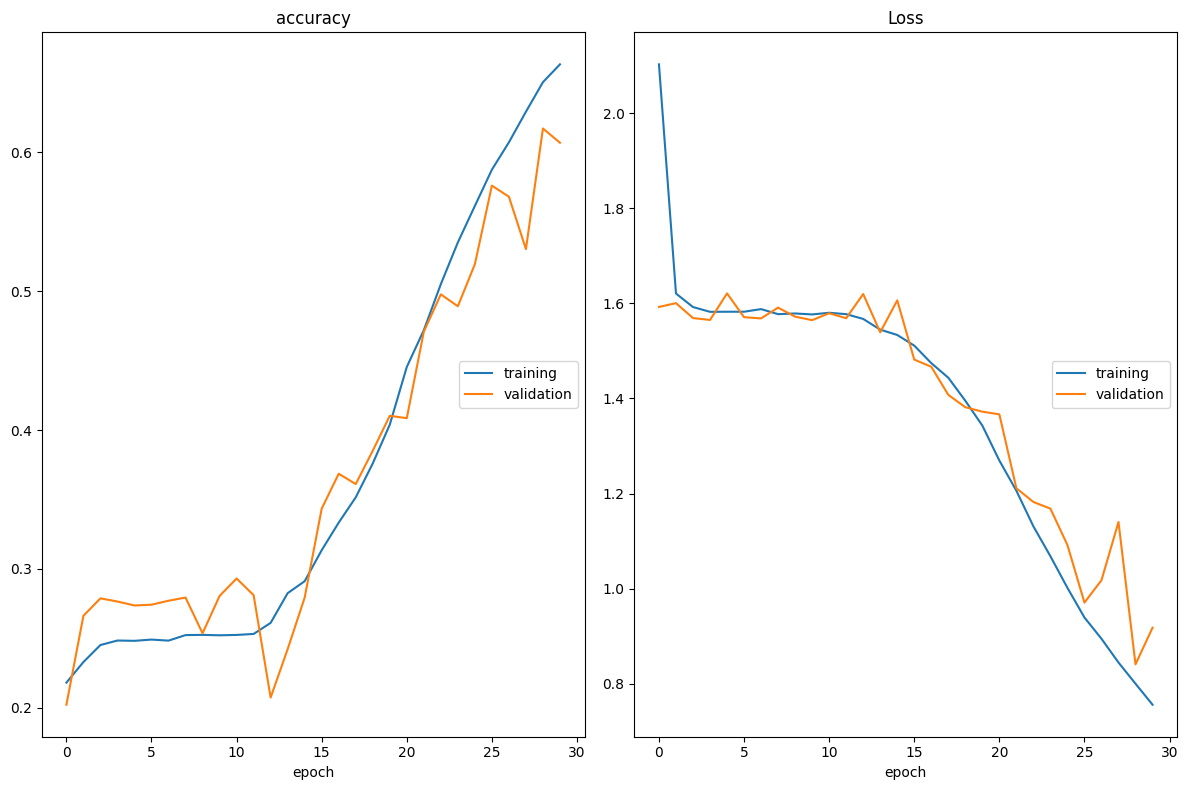

accuracy
	training         	 (min:    0.218, max:    0.663, cur:    0.663)
	validation       	 (min:    0.202, max:    0.617, cur:    0.607)
Loss
	training         	 (min:    0.756, max:    2.102, cur:    0.756)
	validation       	 (min:    0.841, max:    1.621, cur:    0.918)
832/832 [==============================] - 404s 485ms/step - loss: 0.7561 - accuracy: 0.6633 - val_loss: 0.9179 - val_accuracy: 0.6069


In [ ]:
model = alexnet_model.fit(train_generator, epochs =30, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

###### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

6650/6650 [==============================] - 104s 16ms/step


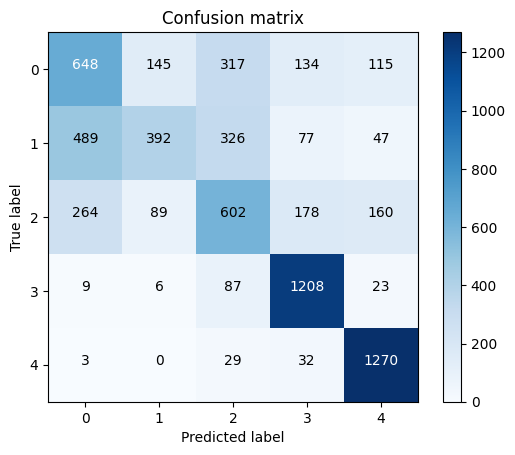

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.6195488721804512


> In this experiment, we employ a modified version of the previously utilized custom pre-processing function for image data, and retrain the AlexNet model over 30 epochs. The major difference in this function is the absence of the final conversion of images to grayscale, meaning the model is trained with full-color images.

> The result of this modification is a significant increase in model accuracy. The training accuracy increases to 66.33%, the validation accuracy to 60.69%, and the testing accuracy to 61.95%.

> Preserving the color information in the images appears to have considerably enhanced the model's ability to capture relevant patterns in the data, leading to improved predictive capabilities. This improvement suggests that the color data in the images may contain significant information for the tasks at hand, and discarding this information through grayscale conversion in the previous experiments might have limited the model's performance.

### 3.8. Picture Refine 3 - Training Model

#### a. Picture Refine

In [ ]:
train_data, validate_data = train_test_split(data_frame, test_size=0.05, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(26600, 2)
(6650, 2)
(1750, 2)


In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


#### a. Using AlexNet - Convolutional Neural Network (CNN)

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
alexnet_model = alexnet_network(input_shape, 5)

In [ ]:
alexnet_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

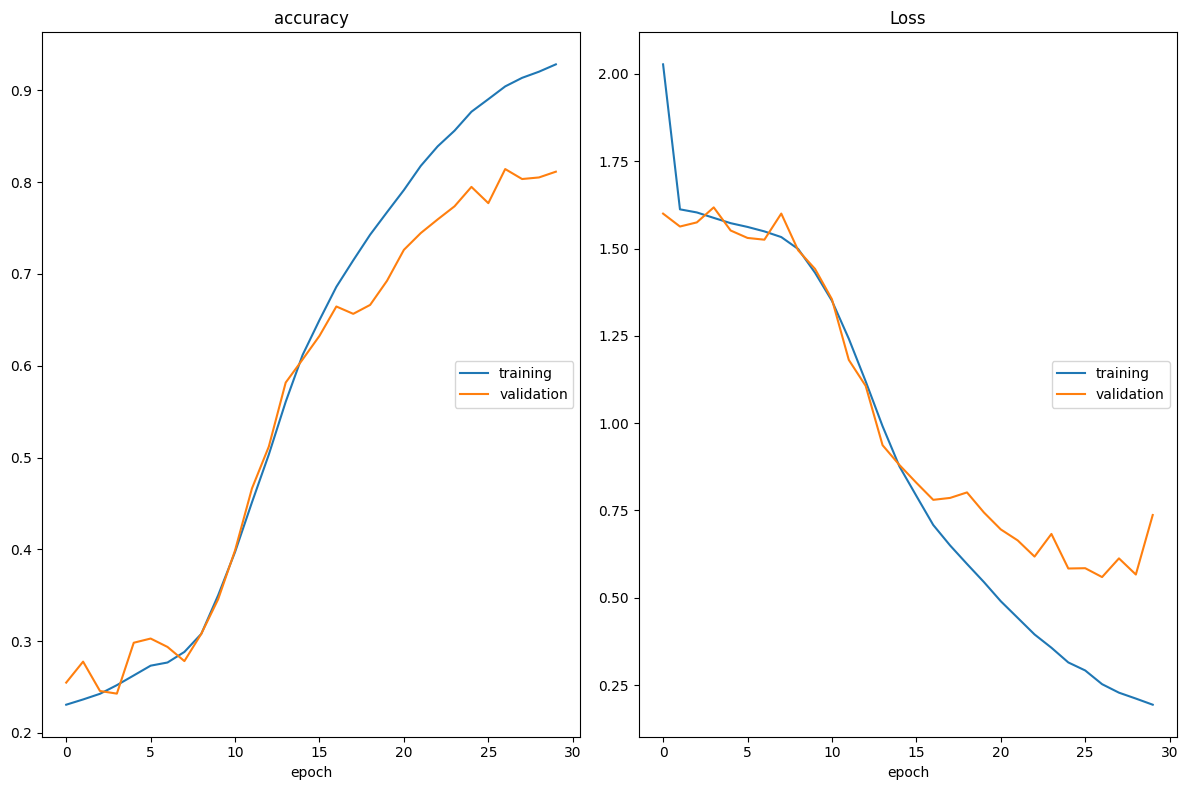

accuracy
	training         	 (min:    0.231, max:    0.928, cur:    0.928)
	validation       	 (min:    0.243, max:    0.814, cur:    0.811)
Loss
	training         	 (min:    0.194, max:    2.027, cur:    0.194)
	validation       	 (min:    0.559, max:    1.618, cur:    0.737)
832/832 [==============================] - 378s 455ms/step - loss: 0.1938 - accuracy: 0.9283 - val_loss: 0.7370 - val_accuracy: 0.8114


In [ ]:
model = alexnet_model.fit(train_generator, epochs =30, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(alexnet_model, test_generator, 1)

6650/6650 [==============================] - 96s 14ms/step


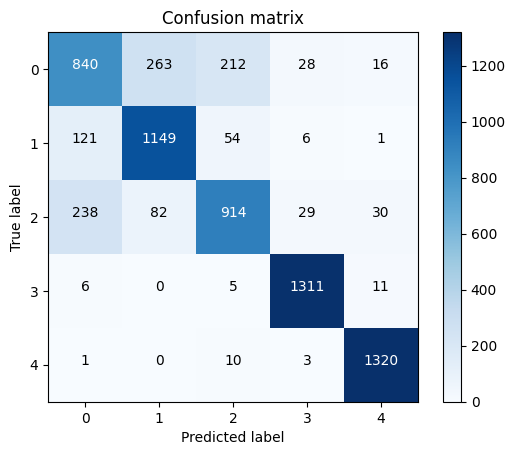

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.8321804511278196


> In this iteration of the experiment, we simplify the pre-processing stage of the images significantly by applying only a rescaling transformation to the input images before training the AlexNet model over 30 epochs. This rescaling operation normalizes the pixel values in the images, dividing them by 255 to ensure they fall within the range 0-1.

> The results from this modification are quite remarkable. We observe a substantial increase in model performance across all categories. Specifically, the training accuracy soars to 92.83%, while the validation and testing accuracies also improve significantly, registering at 81.14% and 83.21% respectively.

> By reducing the pre-processing to only rescaling, we remove the random transformations previously applied, such as flipping, rotation, and brightness and contrast adjustments. The improved performance suggests that, at least for this particular task and dataset, these transformations may have introduced unnecessary variability into the training data, making it more challenging for the model to learn the underlying patterns.

#### b. Using Own Convolutional Neural Network (CNN)

In [ ]:
def own_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(192, (11, 11), padding='same', activation='relu'),
        layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
input_shape = (224, 224, 3)
own_model = own_network(input_shape, 5)

In [ ]:
own_model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
own_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 192)       2230464   
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 192)      0         
 ooling2D)                                                       
                                                        

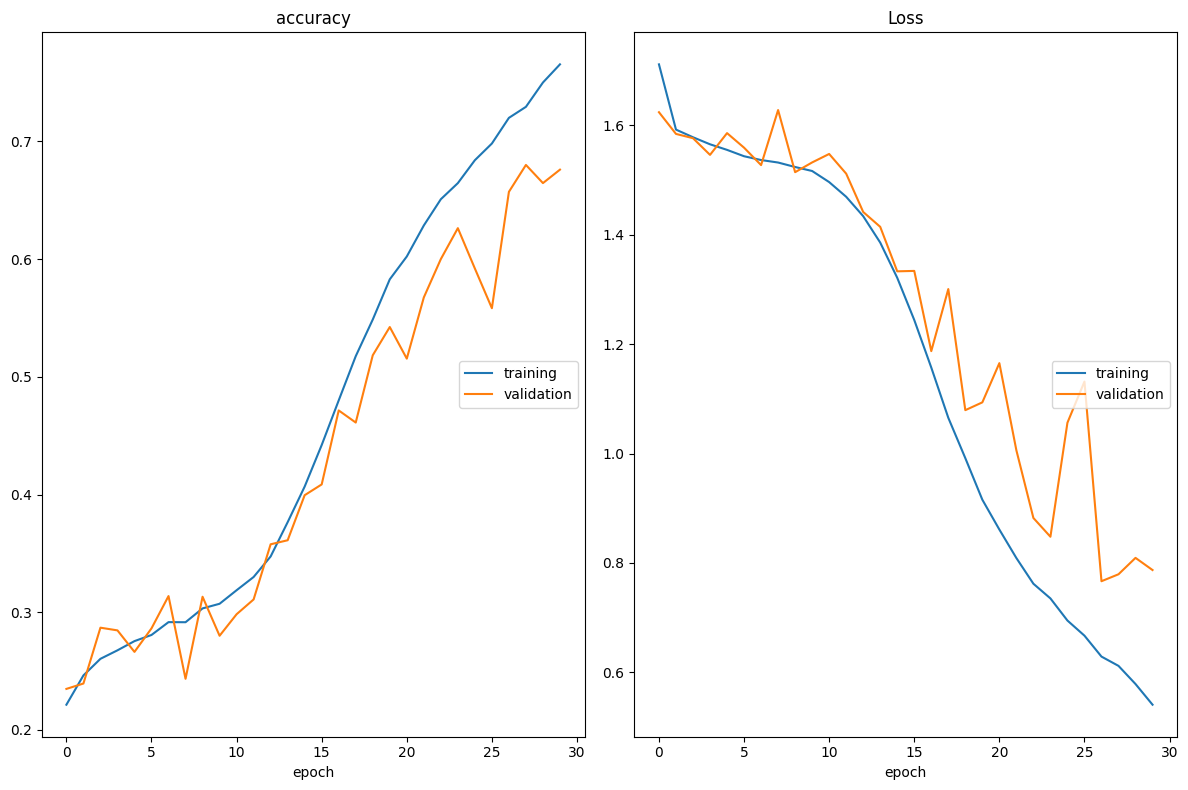

accuracy
	training         	 (min:    0.221, max:    0.765, cur:    0.765)
	validation       	 (min:    0.235, max:    0.680, cur:    0.676)
Loss
	training         	 (min:    0.541, max:    1.712, cur:    0.541)
	validation       	 (min:    0.767, max:    1.628, cur:    0.787)
832/832 [==============================] - 376s 451ms/step - loss: 0.5408 - accuracy: 0.7655 - val_loss: 0.7870 - val_accuracy: 0.6760


In [ ]:
model = own_model.fit(train_generator, epochs =30, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(own_model, test_generator, 1)

6650/6650 [==============================] - 97s 14ms/step


In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

> In this stage of the experiment, we have transitioned from using the pre-existing AlexNet architecture to utilizing a custom Convolutional Neural Network (CNN) for model training. The model is trained over 30 epochs and the image pre-processing is maintained as a simple rescaling transformation.

> Following this change, we observe a decrease in training accuracy to 76.55%, while the validation accuracy is at 67.6% and the testing accuracy is at 72.55%. Although these accuracy scores are lower than the previous run with AlexNet, they are still quite substantial and demonstrate the potential of the custom CNN.

#### c. Using Vision Tranformer (ViT)

In [ ]:
def vit_finetune():
  vit_model = vit.vit_b16(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=5
    )
  model = tf.keras.Sequential([
          vit_model,
          layers.Flatten(),
          layers.BatchNormalization(),
          layers.Dense(128, activation = 'relu'),
          layers.BatchNormalization(),
          layers.Dense(32, activation = 'gelu'),
          layers.Dropout(0.3),
          layers.Dense(32, activation = 'gelu'),
          layers.Dropout(0.1),
          layers.Dense(5,  activation = 'softmax')
      ],
      name = 'vision_transformer')

  return model


In [ ]:
vision_trans_model = vit_finetune()

347502902/347502902 [==============================] - 20s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
vision_trans_model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 32)         

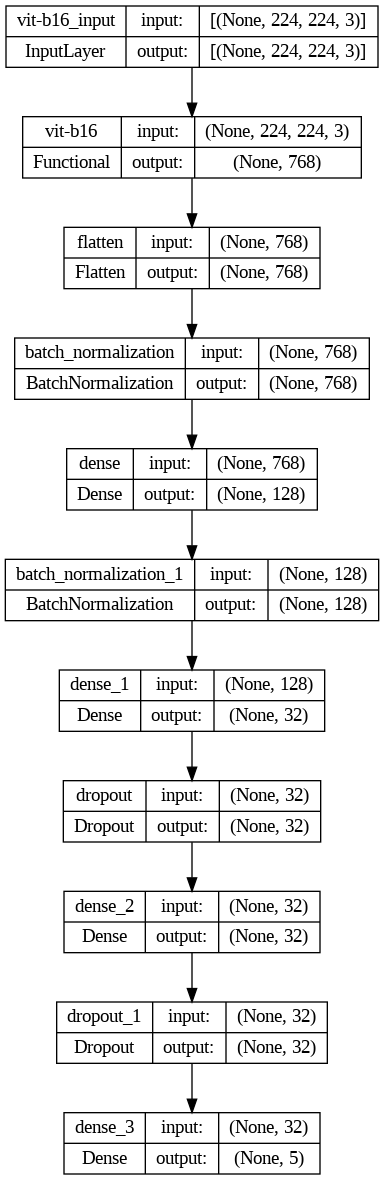

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Assuming you have a model named 'model'
# Visualize the model
plot_model(vision_trans_model, to_file='model.png', show_shapes=True)

In [ ]:
vision_trans_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.05),
    metrics=['accuracy']
)

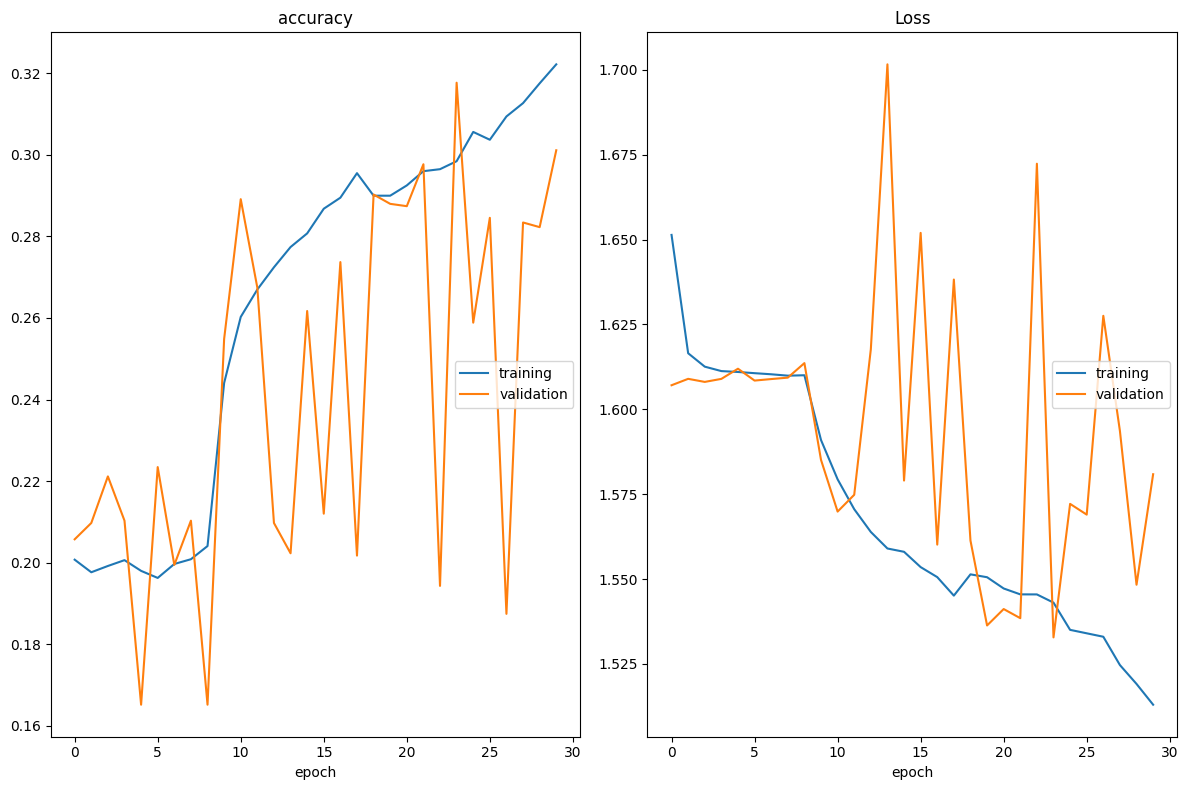

accuracy
	training         	 (min:    0.196, max:    0.322, cur:    0.322)
	validation       	 (min:    0.165, max:    0.318, cur:    0.301)
Loss
	training         	 (min:    1.513, max:    1.651, cur:    1.513)
	validation       	 (min:    1.533, max:    1.702, cur:    1.581)
832/832 [==============================] - 1072s 1s/step - loss: 1.5130 - accuracy: 0.3222 - val_loss: 1.5809 - val_accuracy: 0.3011


In [ ]:
model = vision_trans_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(vision_trans_model, test_generator, 1)

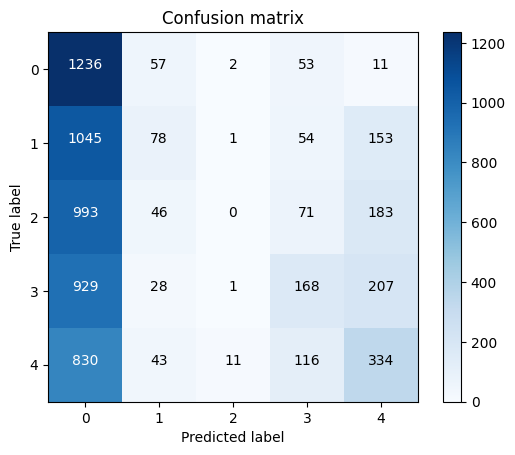

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.2730827067669173


> In this phase of the experiment, we transition from a custom Convolutional Neural Network (CNN) to a Vision Transformer (ViT), a more recent development in the field of computer vision that applies the transformer architecture, originally designed for natural language processing tasks, to image data. The model is trained over 30 epochs with the images pre-processed by simple rescaling.

> The results of this transition show a significant decrease in performance across all accuracy metrics. The training accuracy drops to 32.22%, the validation accuracy to 30.11%, and the testing accuracy to 27.3%.

> The decreased performance with the ViT could be attributed to several factors. First, ViTs often require large amounts of data to train effectively, and they might not perform as well on smaller datasets compared to CNNs. If the dataset used in this experiment is relatively small, this could partially explain the reduced performance.

> Second, ViTs can be more complex and computationally intensive than CNNs, potentially requiring more training time to reach optimal performance. If the 30 epochs used in this experiment are not sufficient for the ViT to fully learn the patterns in the data, this could also contribute to the lower accuracy scores.

#### d. Using Ensemble Learning

In [ ]:
def alexnet_network(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

    ])

    return model


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
restnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
alexnet_model = alexnet_network(input_shape=(224, 224, 3))

def ensemble_model(num_classes):
  input_shape = (224, 224, 3)
  input_layer = layers.Input(shape=input_shape)

  vgg19_output = vgg19_model(input_layer)
  vgg19_flatern = layers.Flatten()(vgg19_output)
  vgg19_dense = Dense(1024, activation='relu')(vgg19_flatern)

  resnet50_output = restnet50_model(input_layer)
  resnet50_flatern = layers.Flatten()(resnet50_output)
  resnet50_dense = Dense(1024, activation='relu')(resnet50_flatern)

  alexnet_output = alexnet_model(input_layer)
  alexnet_dense = Dense(1024, activation='relu')(alexnet_output)


  concat = layers.concatenate([vgg19_dense, alexnet_dense, resnet50_dense])
  concat = layers.Dropout(0.1)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  predictions = layers.Dense(num_classes, activation='softmax')(concat)
  ensemble_model = models.Model(inputs=input_layer, outputs=predictions, name='ensemble_model')
  return ensemble_model

In [ ]:
model_ensemble = ensemble_model(5)

model_ensemble.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

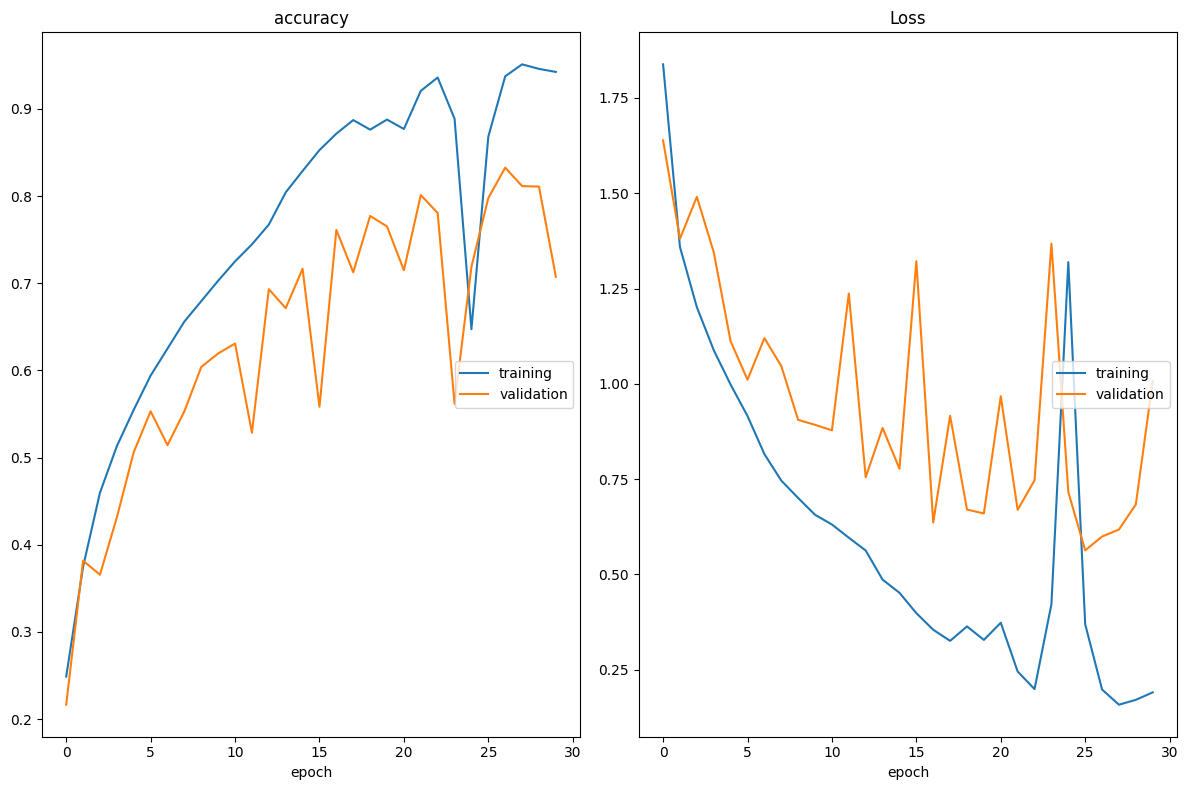

accuracy
	training         	 (min:    0.249, max:    0.951, cur:    0.942)
	validation       	 (min:    0.217, max:    0.833, cur:    0.707)
Loss
	training         	 (min:    0.158, max:    1.838, cur:    0.190)
	validation       	 (min:    0.563, max:    1.639, cur:    1.007)
832/832 [==============================] - 713s 856ms/step - loss: 0.1904 - accuracy: 0.9424 - val_loss: 1.0074 - val_accuracy: 0.7074


In [ ]:
model = model_ensemble.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(model_ensemble, test_generator, 1)

6650/6650 [==============================] - 167s 25ms/step


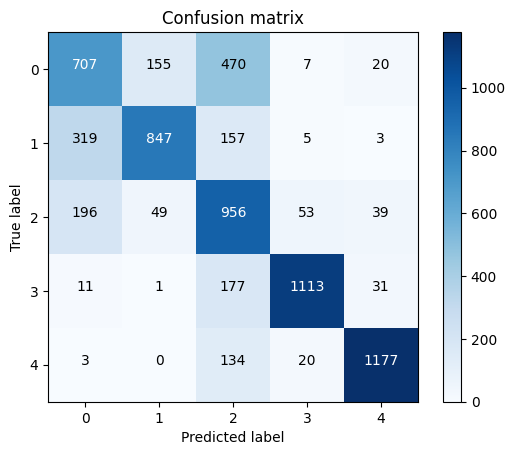

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.7218045112781954


> In the latest phase of this experiment, an ensemble learning approach is adopted, utilizing a combination of AlexNet, VGG19, and ResNet-50 models. The VGG19 and ResNet-50 models are initialized with pre-trained weights from ImageNet, while the AlexNet model presumably starts with random weights, as it's not specified otherwise. The model is trained over 30 epochs and the images are pre-processed through simple rescaling.

> Following this modification, we observe an impressive improvement in the training accuracy, which reaches 94.24%. However, the validation accuracy is recorded at 70.74% and the testing accuracy at 72.18%, which, while being significant, show a substantial gap from the training accuracy.

> The ensemble learning approach combines the strengths of multiple individual models, which can result in more robust and accurate predictions. In this case, the use of pre-trained VGG19 and ResNet-50 models provides the ensemble with a good starting point, as these models have already learned useful features from the large and diverse ImageNet dataset.

### 3.9. Best Model With Ajustment In Hyper-Parameter

#### a. Picture Refine

In [ ]:
train_data, validate_data = train_test_split(data_frame, test_size=0.05, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(26600, 2)
(6650, 2)
(1750, 2)


In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


#### b. Change the Architecture

In [ ]:
def alexnet_network(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

    ])

    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
restnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
alexnet_model = alexnet_network(input_shape=(224, 224, 3))

def ensemble_model(num_classes):
  input_shape = (224, 224, 3)
  input_layer = layers.Input(shape=input_shape)

  vgg19_output = vgg19_model(input_layer)
  vgg19_flatern = layers.Flatten()(vgg19_output)
  vgg19_dense = Dense(1024, activation='selu')(vgg19_flatern)

  resnet50_output = restnet50_model(input_layer)
  resnet50_flatern = layers.Flatten()(resnet50_output)
  resnet50_dense = Dense(1024, activation='selu')(resnet50_flatern)

  alexnet_output = alexnet_model(input_layer)
  alexnet_dense = Dense(1024, activation='selu')(alexnet_output)


  concat = layers.concatenate([vgg19_dense, alexnet_dense, resnet50_dense])
  concat = layers.Dropout(0.1)(concat)
  concat = layers.Dense(1024, activation='gelu')(concat)
  concat = layers.Dropout(0.5)(concat)
  concat = layers.Dense(1024, activation='gelu')(concat)
  concat = layers.Dropout(0.5)(concat)
  predictions = layers.Dense(num_classes, activation='softmax')(concat)
  ensemble_model = models.Model(inputs=input_layer, outputs=predictions, name='ensemble_model')
  return ensemble_model

In [ ]:
model_ensemble = ensemble_model(5)

model_ensemble.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

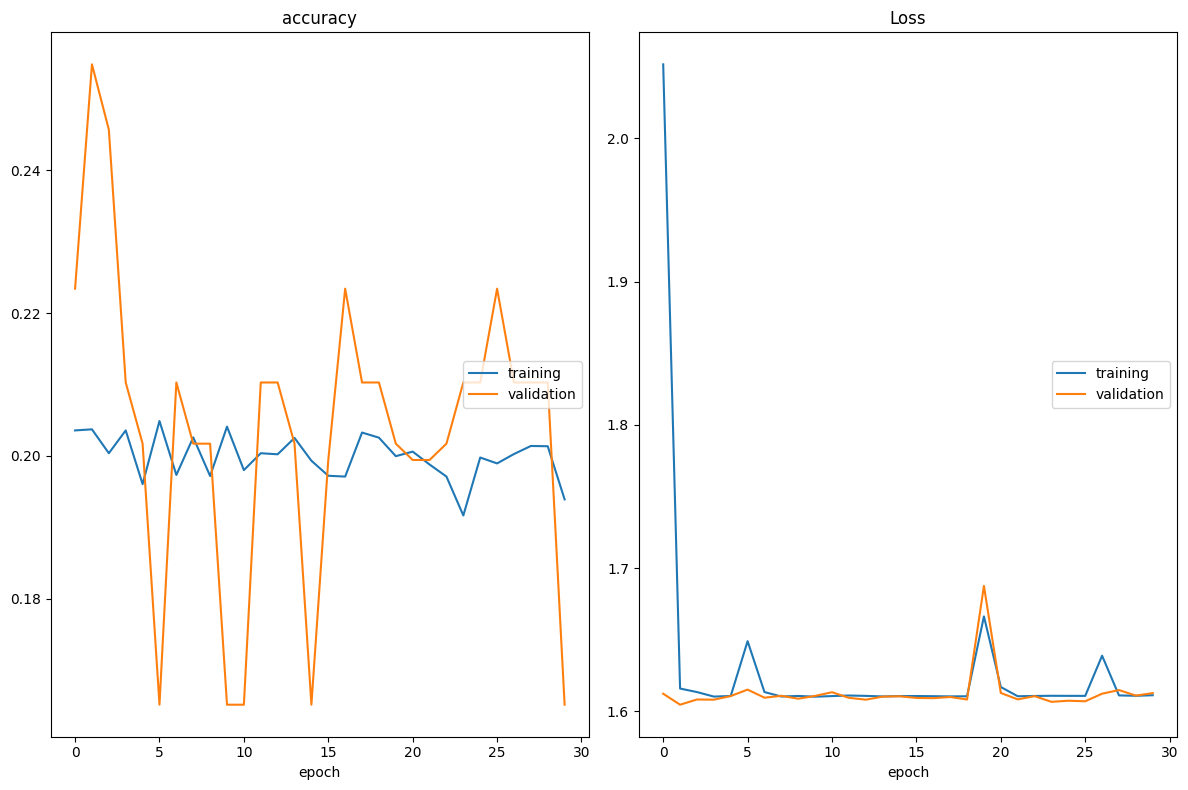

accuracy
	training         	 (min:    0.192, max:    0.205, cur:    0.194)
	validation       	 (min:    0.165, max:    0.255, cur:    0.165)
Loss
	training         	 (min:    1.610, max:    2.052, cur:    1.611)
	validation       	 (min:    1.605, max:    1.688, cur:    1.613)
832/832 [==============================] - 685s 823ms/step - loss: 1.6113 - accuracy: 0.1939 - val_loss: 1.6128 - val_accuracy: 0.1651


In [ ]:
model = model_ensemble.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(model_ensemble, test_generator, 1)

6650/6650 [==============================] - 156s 23ms/step


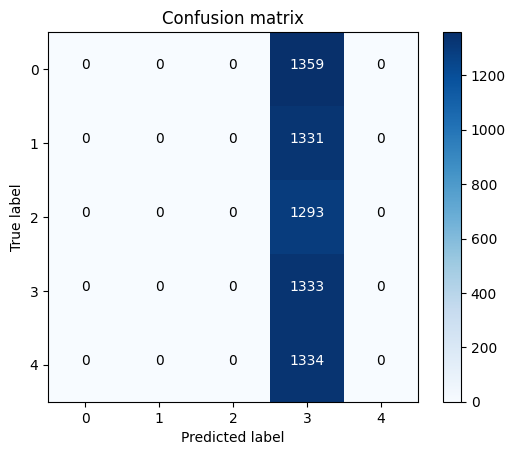

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.20045112781954888


> In this iteration of the experiment, an ensemble learning approach is still employed. However, this time the AlexNet model is replaced by a custom AlexNet variant. The VGG19 and ResNet-50 models continue to be initialized with pre-trained weights from ImageNet. The model is trained for 30 epochs and the images are pre-processed using a simple rescaling operation.

> The outcome of this modification is a significant drop in performance across all accuracy metrics. The training accuracy falls to 19.39%, while the validation and testing accuracies register even lower at 16.51% and 20.04%, respectively.

> The steep decline in performance suggests that the custom AlexNet variant is not as effective as the original AlexNet model for this particular task and dataset. The custom model's architecture or configuration may not be as well-suited to capturing the relevant patterns in the data.

#### c. Change the Epochs

In [ ]:
def alexnet_network(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

    ])

    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
restnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
alexnet_model = alexnet_network(input_shape=(224, 224, 3))

def ensemble_model(num_classes):
  input_shape = (224, 224, 3)
  input_layer = layers.Input(shape=input_shape)

  vgg19_output = vgg19_model(input_layer)
  vgg19_flatern = layers.Flatten()(vgg19_output)
  vgg19_dense = Dense(1024, activation='relu')(vgg19_flatern)

  resnet50_output = restnet50_model(input_layer)
  resnet50_flatern = layers.Flatten()(resnet50_output)
  resnet50_dense = Dense(1024, activation='relu')(resnet50_flatern)

  alexnet_output = alexnet_model(input_layer)
  alexnet_dense = Dense(1024, activation='relu')(alexnet_output)


  concat = layers.concatenate([vgg19_dense, alexnet_dense, resnet50_dense])
  concat = layers.Dropout(0.1)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  predictions = layers.Dense(num_classes, activation='softmax')(concat)
  ensemble_model = models.Model(inputs=input_layer, outputs=predictions, name='ensemble_model')
  return ensemble_model

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
model_ensemble = ensemble_model(5)

model_ensemble.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

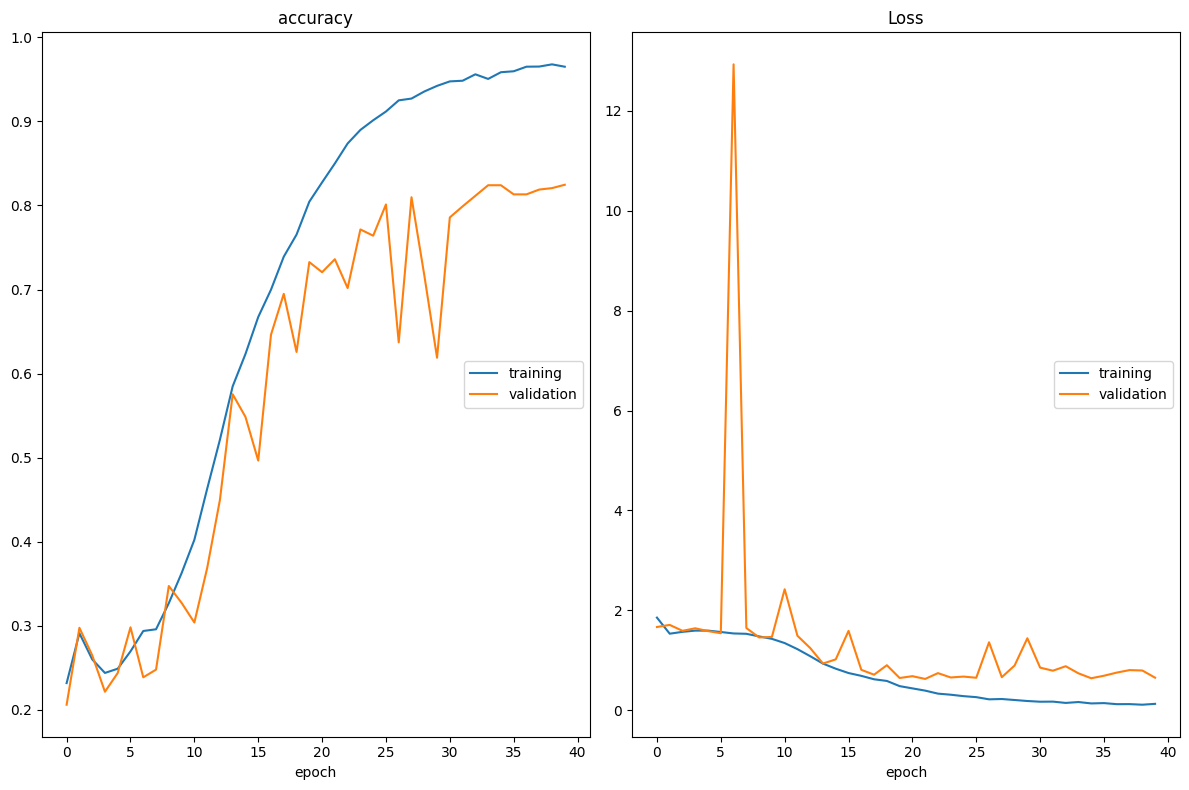

accuracy
	training         	 (min:    0.232, max:    0.968, cur:    0.965)
	validation       	 (min:    0.206, max:    0.825, cur:    0.825)
Loss
	training         	 (min:    0.108, max:    1.853, cur:    0.125)
	validation       	 (min:    0.624, max:   12.934, cur:    0.649)
832/832 [==============================] - 702s 843ms/step - loss: 0.1254 - accuracy: 0.9649 - val_loss: 0.6492 - val_accuracy: 0.8246


In [ ]:
model = model_ensemble.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[PlotLossesKeras()])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(model_ensemble, test_generator, 1)

 252/6650 [>.............................] - ETA: 2:36

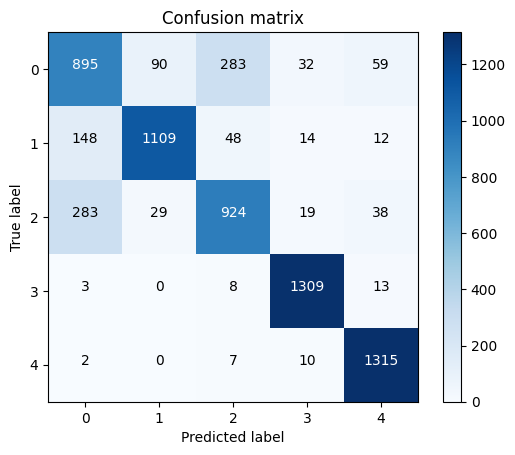

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

> In this phase of the experiment, we continue with the ensemble learning approach, employing a combination of AlexNet, VGG19, and ResNet-50. The VGG19 and ResNet-50 models are pre-trained on ImageNet. However, this time, we increase the number of training epochs from 30 to 40. The image pre-processing remains a simple rescaling operation.

> After increasing the number of training epochs, we observe a noticeable improvement in the model's performance. Specifically, the training accuracy rises to 96.49%. Simultaneously, the validation accuracy improves to 82.46%, and the testing accuracy increases to 86.65%.

> Hence, increasing the number of epochs allows the model more time to learn from the data, potentially leading to more accurate predictions.

#### d. Change the Opitimizer - Reduce Epochs

In [ ]:
def alexnet_network(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

    ])

    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
restnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
alexnet_model = alexnet_network(input_shape=(224, 224, 3))

def ensemble_model(num_classes):
  input_shape = (224, 224, 3)
  input_layer = layers.Input(shape=input_shape)

  vgg19_output = vgg19_model(input_layer)
  vgg19_flatern = layers.Flatten()(vgg19_output)
  vgg19_dense = Dense(1024, activation='relu')(vgg19_flatern)

  resnet50_output = restnet50_model(input_layer)
  resnet50_flatern = layers.Flatten()(resnet50_output)
  resnet50_dense = Dense(1024, activation='relu')(resnet50_flatern)

  alexnet_output = alexnet_model(input_layer)
  alexnet_dense = Dense(1024, activation='relu')(alexnet_output)


  concat = layers.concatenate([vgg19_dense, alexnet_dense, resnet50_dense])
  concat = layers.Dropout(0.1)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  predictions = layers.Dense(num_classes, activation='softmax')(concat)
  ensemble_model = models.Model(inputs=input_layer, outputs=predictions, name='ensemble_model')
  return ensemble_model

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
model_ensemble = ensemble_model(5)

model_ensemble.compile(optimizer=tf.keras.optimizers.experimental.Adamax(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

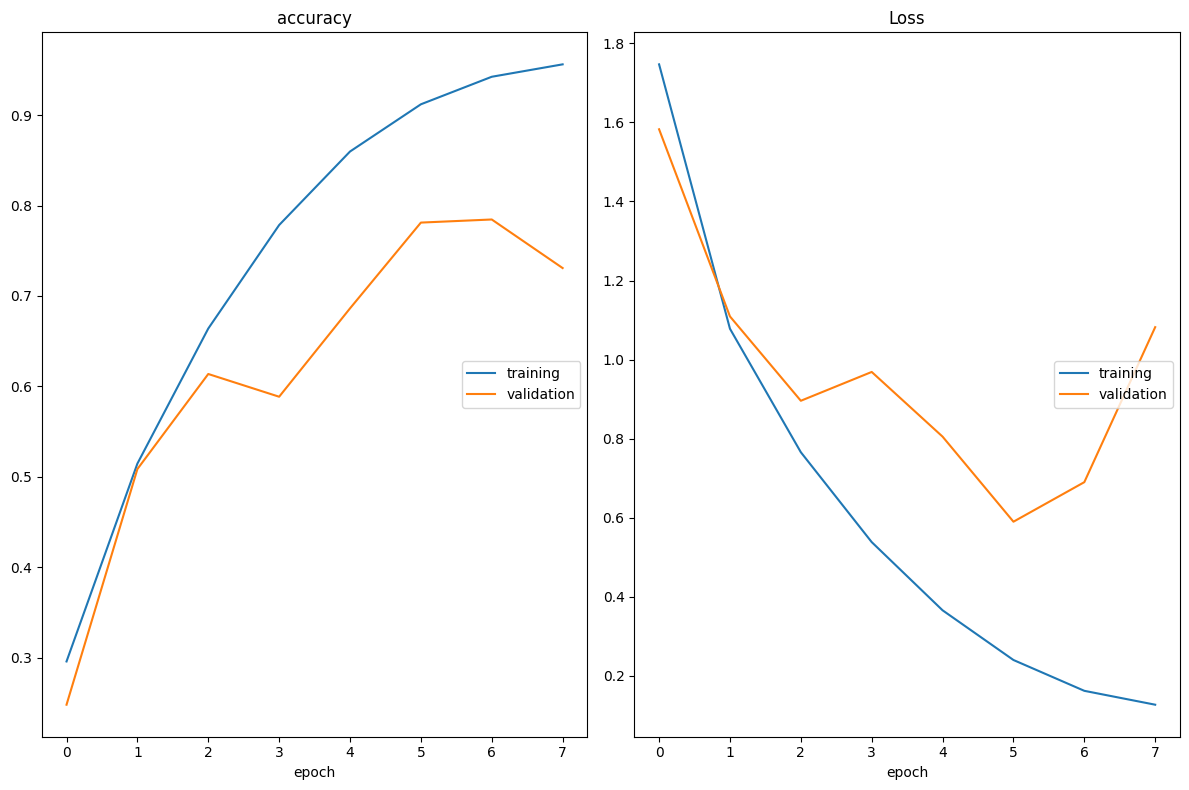

accuracy
	training         	 (min:    0.296, max:    0.956, cur:    0.956)
	validation       	 (min:    0.248, max:    0.785, cur:    0.731)
Loss
	training         	 (min:    0.127, max:    1.747, cur:    0.127)
	validation       	 (min:    0.590, max:    1.582, cur:    1.082)
832/832 [==============================] - 741s 890ms/step - loss: 0.1273 - accuracy: 0.9561 - val_loss: 1.0821 - val_accuracy: 0.7309


In [ ]:
model = model_ensemble.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[PlotLossesKeras(), tf.keras.callbacks.EarlyStopping(patience=2)])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(model_ensemble, test_generator, 1)

6650/6650 [==============================] - 172s 26ms/step


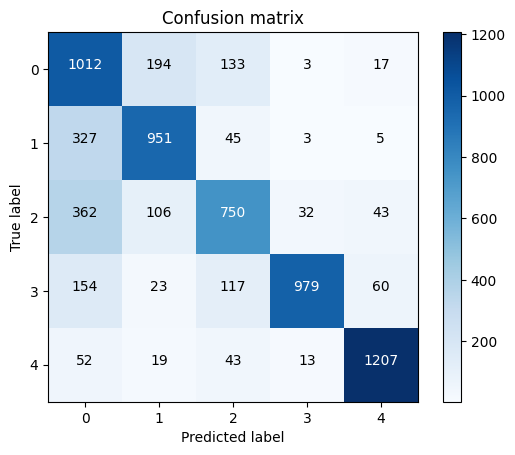

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.7366917293233083


> In this iteration of the experiment, we continue employing an ensemble learning approach that combines the AlexNet, VGG19, and ResNet-50 models, with the latter two pre-trained on ImageNet. However, in contrast to the previous phase, we decrease the number of training epochs from 30 to 10. Furthermore, we switch the optimization algorithm to AdamMax. The image pre-processing remains a simple rescaling operation.

> Upon making these modifications, we observe a high training accuracy of 95.61%, a slight reduction from the previous run. However, the validation accuracy decreases to 73.09% and the testing accuracy to 73.66%.

> Indeed, the use of the AdamMax optimizer, along with the reduction in the number of epochs, has significantly accelerated the training process, reducing it to a third of the original duration. This strategy has led to considerable computational efficiency, which is a valuable asset in machine learning, particularly when dealing with large and complex datasets or models.





#### e. Change the Batch-Size

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


In [ ]:
def alexnet_network(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

    ])

    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
restnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
alexnet_model = alexnet_network(input_shape=(224, 224, 3))

def ensemble_model(num_classes):
  input_shape = (224, 224, 3)
  input_layer = layers.Input(shape=input_shape)

  vgg19_output = vgg19_model(input_layer)
  vgg19_flatern = layers.Flatten()(vgg19_output)
  vgg19_dense = Dense(1024, activation='relu')(vgg19_flatern)

  resnet50_output = restnet50_model(input_layer)
  resnet50_flatern = layers.Flatten()(resnet50_output)
  resnet50_dense = Dense(1024, activation='relu')(resnet50_flatern)

  alexnet_output = alexnet_model(input_layer)
  alexnet_dense = Dense(1024, activation='relu')(alexnet_output)


  concat = layers.concatenate([vgg19_dense, alexnet_dense, resnet50_dense])
  concat = layers.Dropout(0.1)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  predictions = layers.Dense(num_classes, activation='softmax')(concat)
  ensemble_model = models.Model(inputs=input_layer, outputs=predictions, name='ensemble_model')
  return ensemble_model

In [ ]:
model_ensemble = ensemble_model(5)

model_ensemble.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

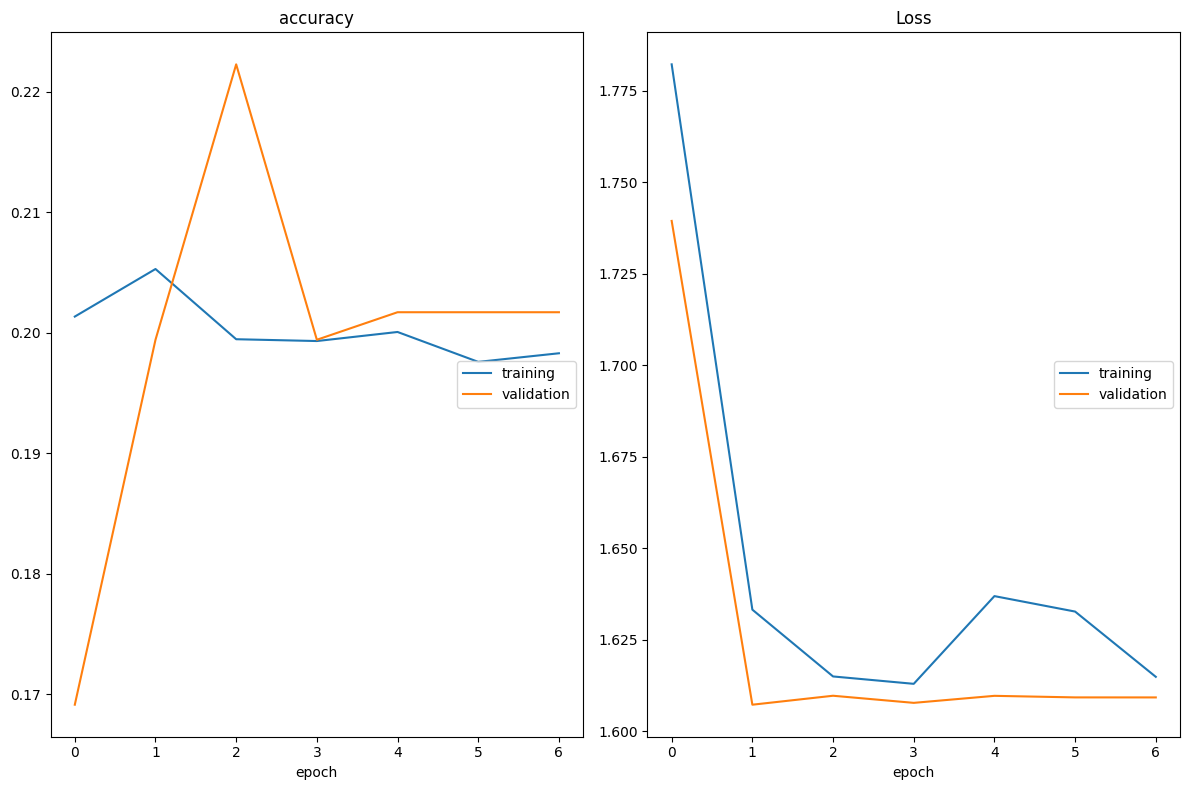

accuracy
	training         	 (min:    0.198, max:    0.205, cur:    0.198)
	validation       	 (min:    0.169, max:    0.222, cur:    0.202)
Loss
	training         	 (min:    1.613, max:    1.782, cur:    1.615)
	validation       	 (min:    1.607, max:    1.739, cur:    1.609)
3325/3325 [==============================] - 1048s 315ms/step - loss: 1.6148 - accuracy: 0.1983 - val_loss: 1.6092 - val_accuracy: 0.2017


In [ ]:
model = model_ensemble.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[PlotLossesKeras(), tf.keras.callbacks.EarlyStopping(patience=5)])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(model_ensemble, test_generator, 1)

6650/6650 [==============================] - 168s 25ms/step


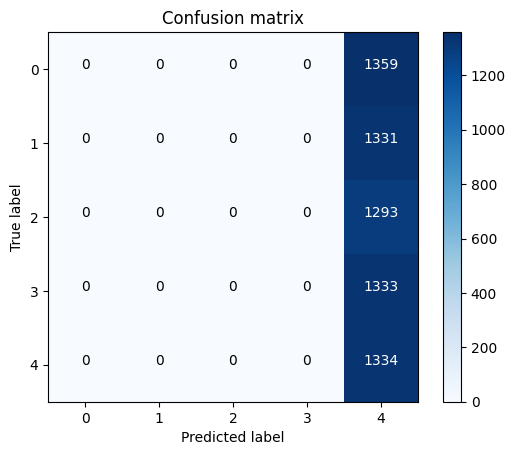

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.2006015037593985


> In the most recent iteration of this experiment, we maintain the ensemble learning approach, employing a combination of AlexNet, VGG19, and ResNet-50, with the latter two models pre-trained on ImageNet. However, we make a significant change by reducing the batch size from 32 to 8. The image pre-processing protocol remains a simple rescaling operation.

> Upon reducing the batch size, we observe a considerable decrease in performance across all accuracy metrics. The training accuracy drops to 19.83%, while the validation accuracy reaches 20.17%, and the testing accuracy is recorded at 20.06%.

> Batch size refers to the number of training examples utilized in one iteration. The choice of batch size can significantly impact model training. Larger batch sizes allow for more accurate estimates of the gradient but come with increased computational cost. Smaller batch sizes, on the other hand, are computationally more efficient but might lead to less stable training due to noisier gradient estimates.

#### f. Change the Loss

In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


In [ ]:
def alexnet_network(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

    ])

    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
restnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
alexnet_model = alexnet_network(input_shape=(224, 224, 3))

def ensemble_model(num_classes):
  input_shape = (224, 224, 3)
  input_layer = layers.Input(shape=input_shape)

  vgg19_output = vgg19_model(input_layer)
  vgg19_flatern = layers.Flatten()(vgg19_output)
  vgg19_dense = Dense(1024, activation='relu')(vgg19_flatern)

  resnet50_output = restnet50_model(input_layer)
  resnet50_flatern = layers.Flatten()(resnet50_output)
  resnet50_dense = Dense(1024, activation='relu')(resnet50_flatern)

  alexnet_output = alexnet_model(input_layer)
  alexnet_dense = Dense(1024, activation='relu')(alexnet_output)


  concat = layers.concatenate([vgg19_dense, alexnet_dense, resnet50_dense])
  concat = layers.Dropout(0.1)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  predictions = layers.Dense(num_classes, activation='softmax')(concat)
  ensemble_model = models.Model(inputs=input_layer, outputs=predictions, name='ensemble_model')
  return ensemble_model

In [ ]:
model_ensemble = ensemble_model(5)

model_ensemble.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

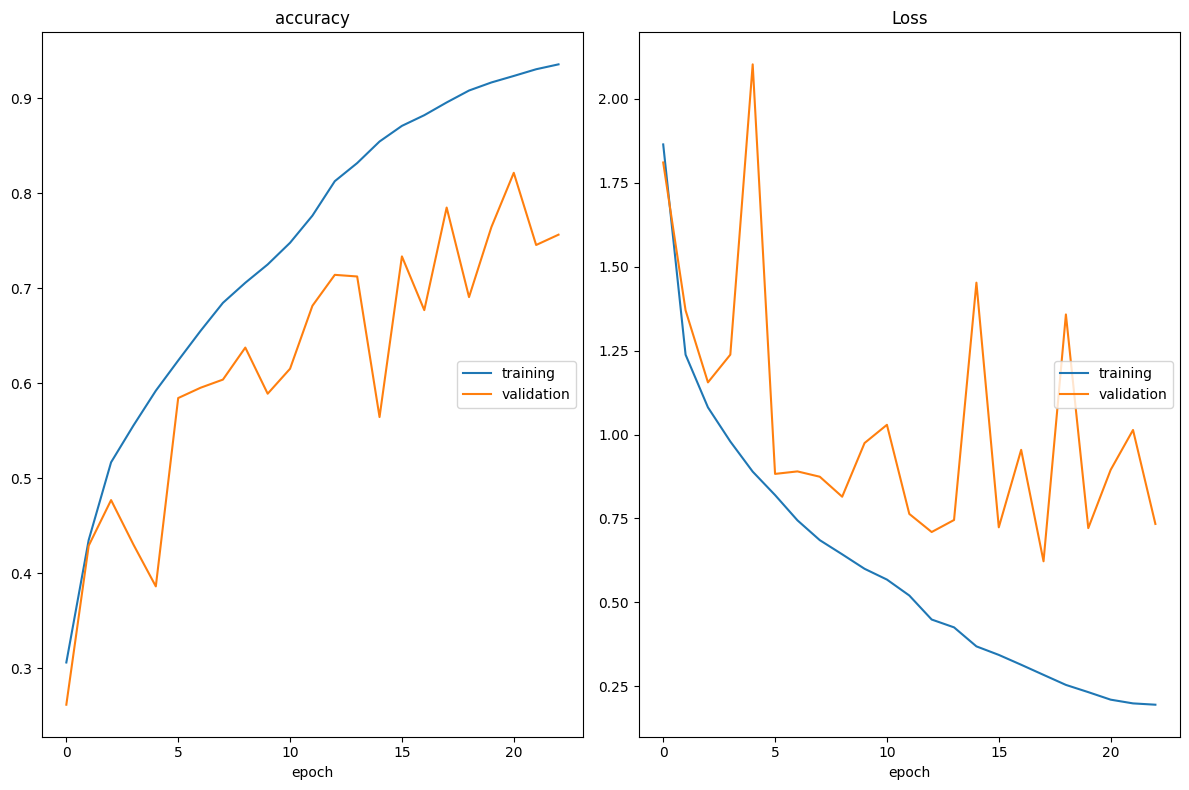

accuracy
	training         	 (min:    0.306, max:    0.936, cur:    0.936)
	validation       	 (min:    0.262, max:    0.822, cur:    0.757)
Loss
	training         	 (min:    0.195, max:    1.864, cur:    0.195)
	validation       	 (min:    0.622, max:    2.102, cur:    0.734)
832/832 [==============================] - 741s 890ms/step - loss: 0.1952 - accuracy: 0.9359 - val_loss: 0.7336 - val_accuracy: 0.7566


In [ ]:
model = model_ensemble.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[PlotLossesKeras(), tf.keras.callbacks.EarlyStopping(patience=5)])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(model_ensemble, test_generator, 1)

6650/6650 [==============================] - 163s 24ms/step


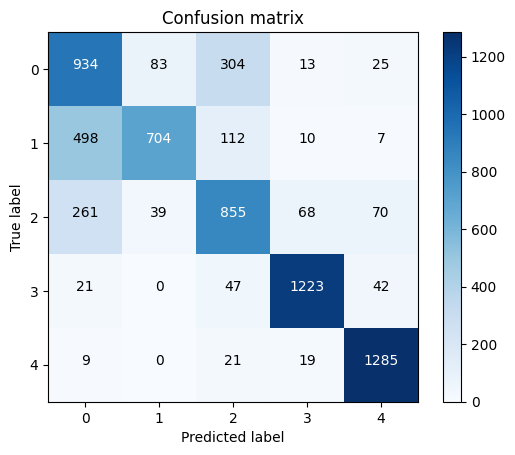

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.7520300751879699
0.7520300751879699


### 3.9. Best Model Combination

#### a. Picture Processing

In [ ]:
train_data, validate_data = train_test_split(data_frame, test_size=0.05, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(26600, 2)
(6650, 2)
(1750, 2)


In [ ]:
path = '/content/dr_dataset'

data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse',
    shuffle=False,
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=validate_data,
    directory=path,
    x_col='image',
    y_col='level',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
)


Found 26600 validated image filenames belonging to 5 classes.
Found 6650 validated image filenames belonging to 5 classes.
Found 1750 validated image filenames belonging to 5 classes.


#### b. Model Setup & Train

In [ ]:
def alexnet_network(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),

    ])

    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
restnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
alexnet_model = alexnet_network(input_shape=(224, 224, 3))

def ensemble_model(num_classes):
  input_shape = (224, 224, 3)
  input_layer = layers.Input(shape=input_shape)

  vgg19_output = vgg19_model(input_layer)
  vgg19_flaten = layers.Flatten()(vgg19_output)
  vgg19_dense = Dense(1024, activation='relu')(vgg19_flaten)

  resnet50_output = restnet50_model(input_layer)
  resnet50_flaten = layers.Flatten()(resnet50_output)
  resnet50_dense = Dense(1024, activation='relu')(resnet50_flaten)

  alexnet_output = alexnet_model(input_layer)
  alexnet_dense = Dense(1024, activation='relu')(alexnet_output)


  concat = layers.concatenate([vgg19_dense, alexnet_dense, resnet50_dense])
  concat = layers.Dropout(0.1)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  concat = layers.Dense(1024, activation='relu')(concat)
  concat = layers.Dropout(0.5)(concat)
  predictions = layers.Dense(num_classes, activation='softmax')(concat)
  ensemble_model = models.Model(inputs=input_layer, outputs=predictions, name='ensemble_model')
  return ensemble_model

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model_ensemble = ensemble_model(5)

model_ensemble.compile(optimizer=tf.keras.optimizers.experimental.Adamax(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

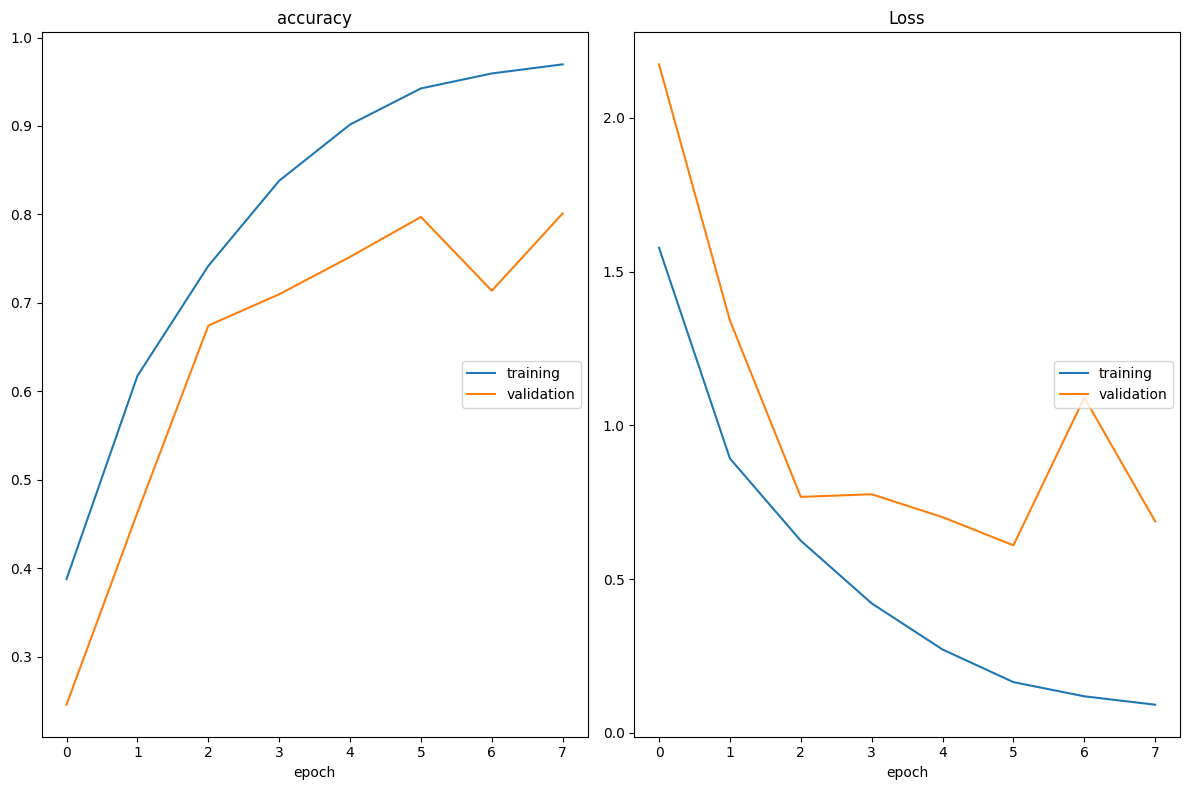

accuracy
	training         	 (min:    0.388, max:    0.970, cur:    0.970)
	validation       	 (min:    0.246, max:    0.801, cur:    0.801)
Loss
	training         	 (min:    0.091, max:    1.578, cur:    0.091)
	validation       	 (min:    0.610, max:    2.174, cur:    0.688)
832/832 [==============================] - 722s 867ms/step - loss: 0.0913 - accuracy: 0.9697 - val_loss: 0.6878 - val_accuracy: 0.8011


In [ ]:
model = model_ensemble.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[PlotLossesKeras(), tf.keras.callbacks.EarlyStopping(patience=2)])

##### Testing & Evaluate Model

In [ ]:
def model_predict(model, data_generator, batch_size):
  steps = data_generator.n // batch_size
  y_pred = model.predict(data_generator, steps=steps)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes
  return y_pred, y_true

In [ ]:
y_pred, y_true = model_predict(model_ensemble, test_generator, 1)

6650/6650 [==============================] - 168s 25ms/step


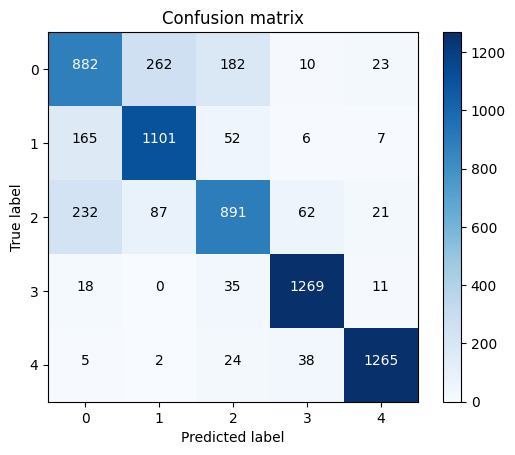

In [ ]:
plot_confusion_matrix(y_true, y_pred)

In [ ]:
acc = accuracy_calculation(y_true, y_pred)
print(acc)

0.8132330827067669


#### c. Model Saving - Downloading

In [ ]:
model_ensemble.save('aml_hungle_surrey_2023')

In [ ]:
# Download model
shutil.make_archive('aml_model', 'zip', 'aml_hungle_surrey_2023')
files.download('aml_model.zip')

### 3.10. Knowledge Distillation - Transfer Knowledge - Heat Map

#### a. Model Loading & Prediction

In [ ]:
drive.mount('/content/drive/')
clear_output()

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Applied Machine Learning/AML_Model/aml_model.zip" -d /content/aml_model/
clear_output()

In [ ]:
teacher_model = tf.keras.models.load_model("/content/aml_model")

In [ ]:
teacher_model.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_6[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_6[0][0]']                
                                                                                                  
 flatten_4 (Flatten)            (None, 25088)        0           ['vgg19[0][0]']     

In [ ]:
def model_predict(model, image_generator):
  image_data, y_true = next(image_generator)
  y_pred = model.predict(image_data)
  y_pred = np.argmax(y_pred, axis=1)
  return image_data, y_pred[0], int(y_true)

In [ ]:
image_data, y_pred, y_true = model_predict(teacher_model, test_generator)

1/1 [==============================] - 2s 2s/step


In [ ]:
print(y_pred, y_true)

4 4


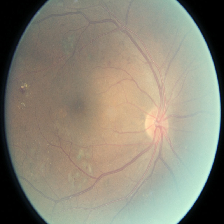

In [ ]:
image_data_show = (image_data.squeeze() * 255).astype(np.uint8)
pil_image = Image.fromarray(image_data_show)
pil_image.show()

#### b. Create Student Model & Transfering Knowlegde & Saving Student Model

In [ ]:
def alexnet_network(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    return model

In [ ]:
input_shape=(224, 224, 3)
student_model = alexnet_network(input_shape, 5)

In [ ]:
from tensorflow import keras

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=tf.keras.optimizers.experimental.Adamax(),
    metrics=['accuracy'],
    student_loss_fn=tf. keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=5,
)

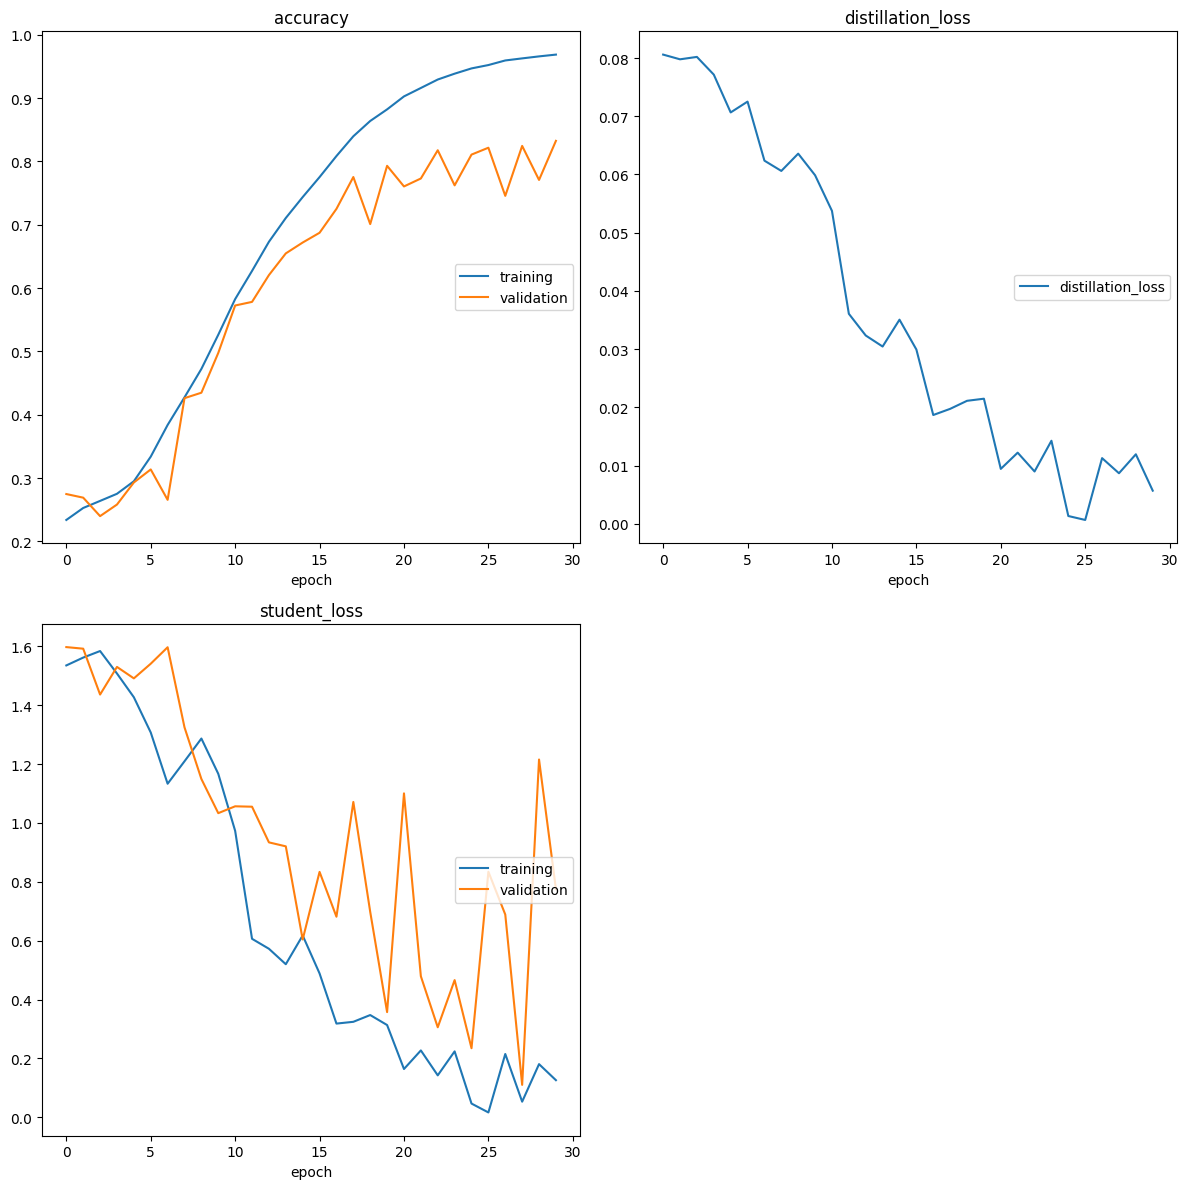

accuracy
	training         	 (min:    0.234, max:    0.969, cur:    0.969)
	validation       	 (min:    0.240, max:    0.833, cur:    0.833)
distillation_loss
	distillation_loss 	 (min:    0.001, max:    0.081, cur:    0.006)
student_loss
	training         	 (min:    0.017, max:    1.584, cur:    0.126)
	validation       	 (min:    0.110, max:    1.597, cur:    0.775)
832/832 [==============================] - 442s 531ms/step - accuracy: 0.9688 - student_loss: 0.0881 - distillation_loss: 0.0067 - val_accuracy: 0.8326 - val_student_loss: 0.7751


In [ ]:
distiller.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[PlotLossesKeras(), tf.keras.callbacks.EarlyStopping(patience=5)])

In [ ]:
student_model.save('aml_hungle_surrey_2023_kd')

In [ ]:
# Download model
shutil.make_archive('kd_model', 'zip', 'aml_hungle_surrey_2023_kd')
files.download('kd_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### c. Load Student Model & Prediction & Create Heat Map

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Applied Machine Learning/AML_Model/kd_model.zip" -d /content/kd_model/
clear_output()

In [ ]:
model = tf.keras.models.load_model("/content/kd_model")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
def gradCAM(model, image_data, intensity=0.1):

  preds = model.predict(image_data)
  image_class = np.argmax(preds, axis=1)
  print(image_class)

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_4')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(image_data)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))


  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((12, 12))

  img = (image_data.squeeze() * 255).astype(np.uint8)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img


  cv2_imshow(img)

1/1 [==============================] - 0s 21ms/step
[1]


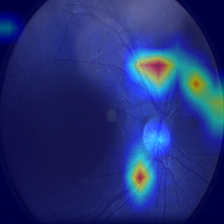

In [ ]:
image_data, y_true = next(test_generator)
gradCAM(model, image_data, intensity=0.5)